In [1]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
import sys
import os
import matplotlib.pyplot as plt

sys.path.append(os.path.abspath('../'))

from src.tabddpm.hyperparameter_tuning import hyperparameter_search
from src.tabddpm.training import Trainer, get_diffusion_model
from src.tabddpm.denoising_model import MLPDenoiser
from src.tabddpm.evaluate import evaluate_mixed_loss


In [2]:
file_path = '../data/preprocessed/1480/data_processed.csv'

df = pd.read_csv(file_path)

df.head()


,V1,V10,V3,V4,V5,V6,V7,V8,V9,V2
0,1.190940,-0.151318,-1.016737,-5.199338,-0.444948,-1.411573,-1.350125,0.188461,0.212631,0.0
1,1.020355,-0.645041,1.405765,1.423335,1.646522,0.740885,0.801780,0.970866,0.110048,1.0
2,1.020355,-0.283710,1.235902,1.288435,1.231294,0.655684,0.493028,0.440198,0.212631,1.0
3,0.707298,0.270284,0.000000,0.116550,-0.534807,-1.746316,-1.144112,0.188461,0.306203,1.0
4,1.672115,-1.991811,0.930265,0.926951,-0.245794,-0.400208,0.376984,0.792902,-0.907275,1.0


In [3]:
df.shape

(583, 10)

In [4]:
num_numerical = 9
num_classes=[2]
d_in = num_numerical + sum(num_classes)

X = torch.tensor(df.values, dtype=torch.float32)
batch_size = 32
data_loader = DataLoader(TensorDataset(X), batch_size=batch_size, shuffle=True)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
search_space = {
    'd_layers': [[128, 128], [256, 128, 64], [264, 264, 264], [512, 256, 128]],
    'dropout': [0.0, 0.1],
    'd_t': [64, 128],
    'lr': [1e-3, 5e-4]
}

best_config, best_model_state, best_loss, best_loss_random = hyperparameter_search(
    data_loader=data_loader,
    num_classes=num_classes,  # replace with your dataset
    num_numerical=num_numerical,
    device=device,
    steps=1000,
    search_space=search_space
)

print("✅ Best config:", best_config)
print("📉 Best loss:", best_loss)
print("📉 Random loss:", best_loss_random)




🔍 Trying config: {'d_layers': [128, 128], 'dropout': 0.0, 'd_t': 64, 'lr': 0.001}
[0/1000] Loss: 2.5120
[100/1000] Loss: 1.2136
[200/1000] Loss: 1.9624
[300/1000] Loss: 1.5258
[400/1000] Loss: 1.2957
[500/1000] Loss: 1.4828
[600/1000] Loss: 1.0183
[700/1000] Loss: 0.8129
[800/1000] Loss: 0.9552
[900/1000] Loss: 0.8678
Overall Average Loss: 1.1002, Random Loss: 2.6667

🔍 Trying config: {'d_layers': [128, 128], 'dropout': 0.0, 'd_t': 64, 'lr': 0.0005}
[0/1000] Loss: 2.2945
[100/1000] Loss: 1.5122
[200/1000] Loss: 1.5747
[300/1000] Loss: 0.9962
[400/1000] Loss: 1.1356
[500/1000] Loss: 1.2081


KeyboardInterrupt: 

In [5]:
d_layers = [264, 264, 264]
dropout = 0.0
d_t = 32
steps = 1000
lr = 1e-3
random_loss = 2.7932

In [6]:
model = MLPDenoiser(
    d_in=d_in,
    d_layers=d_layers,
    dropout=dropout,
    d_t=d_t
).to(device)

# Wrap with diffusion model
diffusion = get_diffusion_model(model, num_classes, num_numerical, device)

# Train
trainer = Trainer(diffusion, data_loader, device, steps=steps, lr=lr)
losses, overall_losses, reconstruction_dfs = trainer.train()

[0/1000] Loss: 2.1988
[100/1000] Loss: 1.2038
[200/1000] Loss: 1.3143
[300/1000] Loss: 1.3715
[400/1000] Loss: 1.1670
[500/1000] Loss: 2.3163
[600/1000] Loss: 1.0704
[700/1000] Loss: 0.9595
[800/1000] Loss: 1.0814
[900/1000] Loss: 1.1092


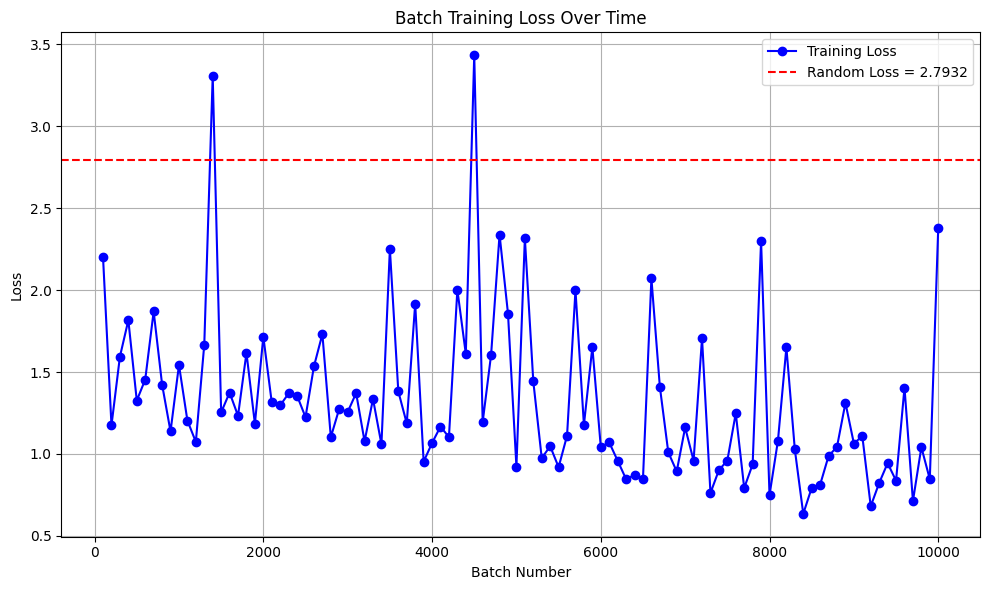

In [7]:
losses_sub = [losses[i] for i in range(0,len(losses), 10)]

x = [100 * (i + 1) for i in range(len(losses_sub))]  # e.g., [100, 200, 300, ...]

plt.figure(figsize=(10, 6))
plt.plot(x, losses_sub, label="Training Loss", color="blue", marker='o')
plt.axhline(y=random_loss, color="red", linestyle="--", label=f"Random Loss = {random_loss:.4f}")

plt.xlabel("Batch Number")
plt.ylabel("Loss")
plt.title("Batch Training Loss Over Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


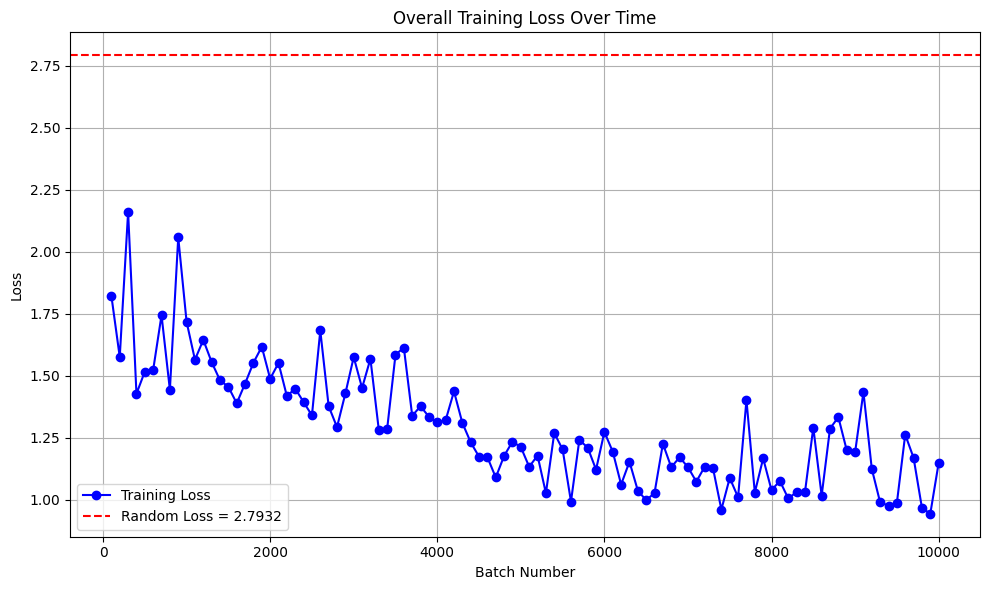

In [8]:
overall_losses_sub = [overall_losses[i] for i in range(0,len(overall_losses), 10)]

x = [100 * (i + 1) for i in range(len(overall_losses_sub))]  # e.g., [100, 200, 300, ...]

plt.figure(figsize=(10, 6))
plt.plot(x, overall_losses_sub, label="Training Loss", color="blue", marker='o')
plt.axhline(y=random_loss, color="red", linestyle="--", label=f"Random Loss = {random_loss:.4f}")

plt.xlabel("Batch Number")
plt.ylabel("Loss")
plt.title("Overall Training Loss Over Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_reconstruction_evolution(df_orig, reconstruction_dfs, i, bins=30):
    feature_name = df_orig.columns[i]
    recon_col_name = reconstruction_dfs[0].columns[i]

    # Calculate fixed axis limits from original distribution
    x_min, x_max = df_orig[feature_name].min(), df_orig[feature_name].max()
    y_max = 0  # We'll compute max histogram height to fix y-axis

    # Pre-compute original histogram to fix y-axis scaling
    counts, bin_edges = np.histogram(df_orig[feature_name], bins=bins, density=True)
    y_max = max(y_max, counts.max())

    for df_recon in reconstruction_dfs:
        step = df_recon['step'].iloc[0]

        # Estimate density for reconstructed to potentially update y_max
        rec_counts, _ = np.histogram(df_recon[recon_col_name], bins=bin_edges, density=True)
        y_max = max(y_max, rec_counts.max())

    for df_recon in reconstruction_dfs:
        step = df_recon['step'].iloc[0]

        plt.figure(figsize=(8, 5))
        sns.histplot(df_orig[feature_name], label="Original", color="black", stat="density", bins=bin_edges)
        sns.histplot(df_recon[recon_col_name], label=f"Reconstructed (step {step})", stat="density", bins=bin_edges, alpha=0.5)

        plt.title(f"Reconstruction at Step {step} — Feature: {feature_name}")
        plt.xlabel("Value")
        plt.ylabel("Density")
        plt.xlim(x_min, x_max)
        plt.ylim(0, y_max * 1.05)  # add slight margin
        plt.legend()
        plt.tight_layout()
        plt.show()


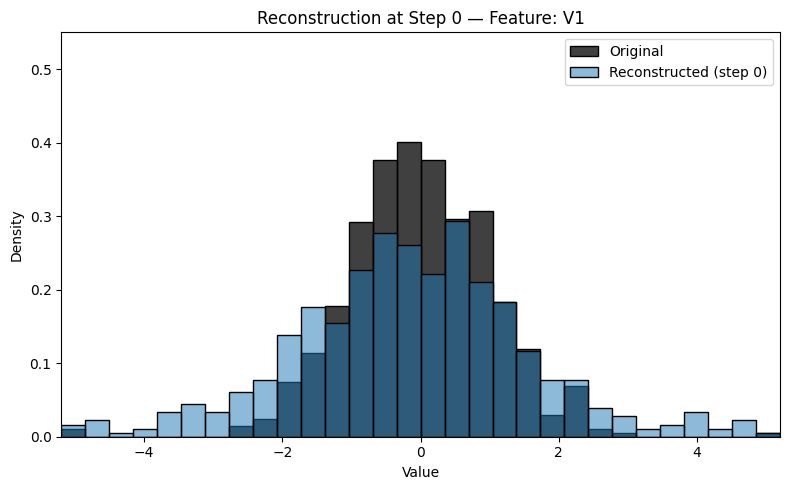

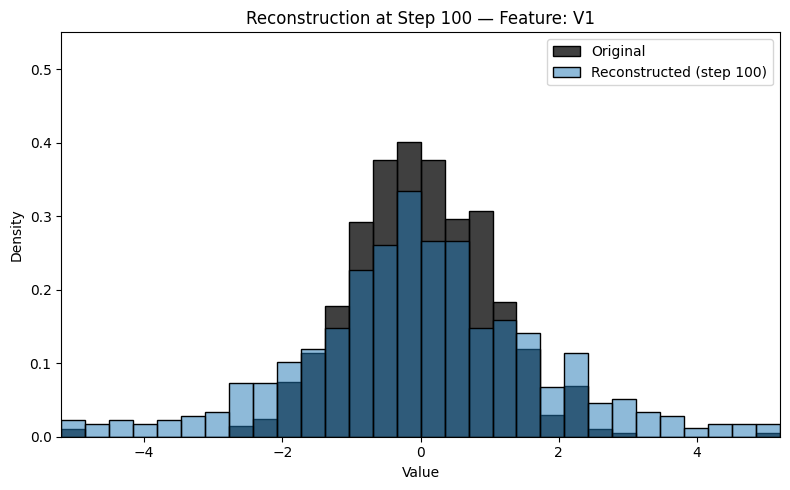

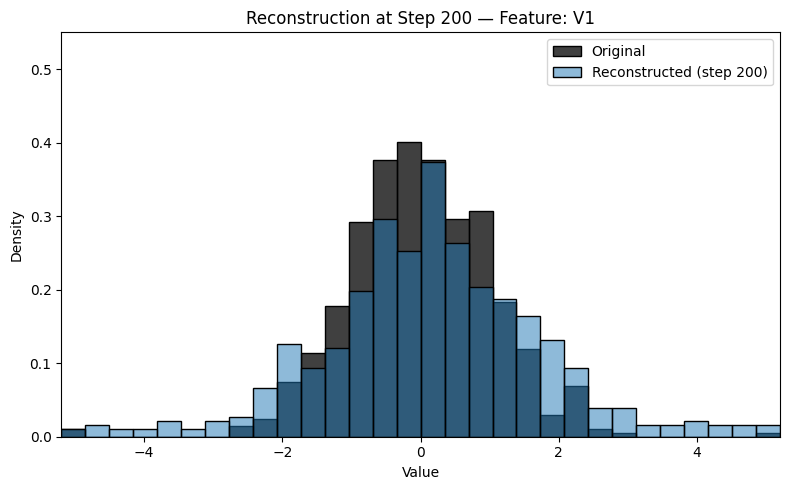

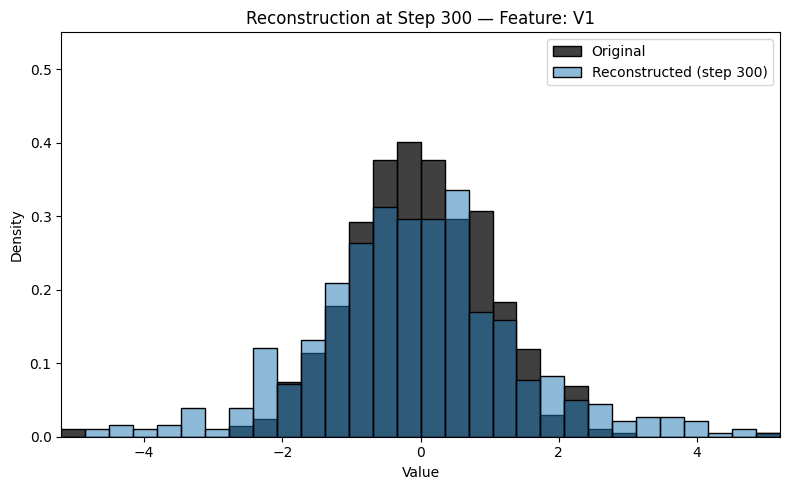

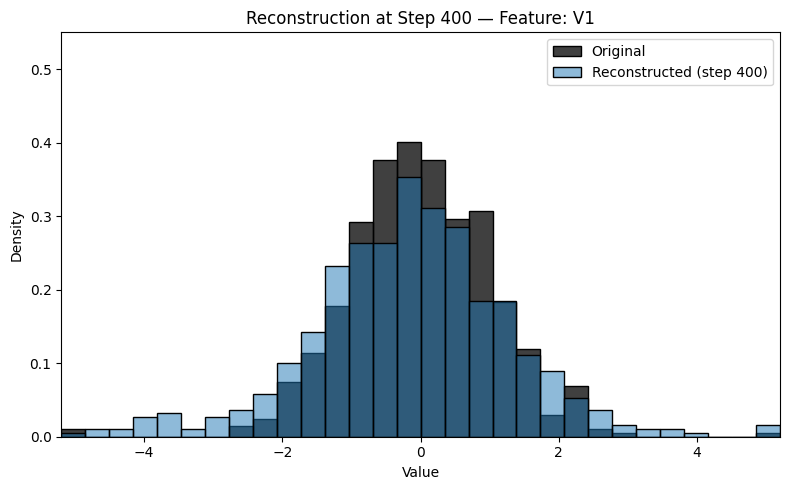

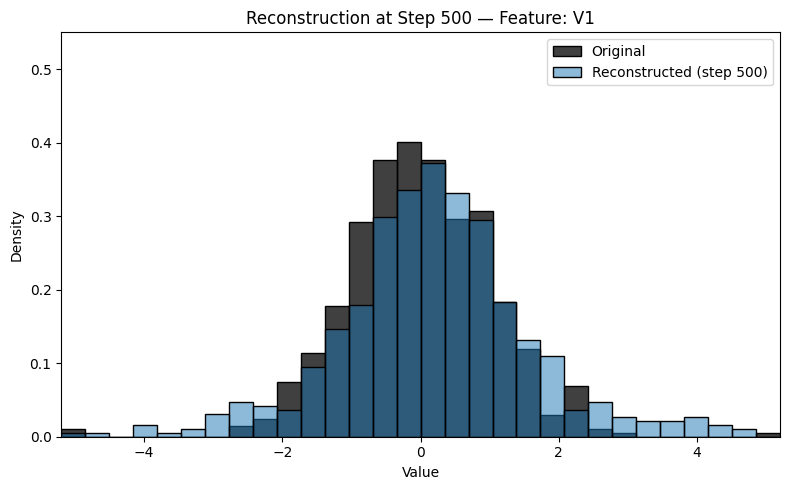

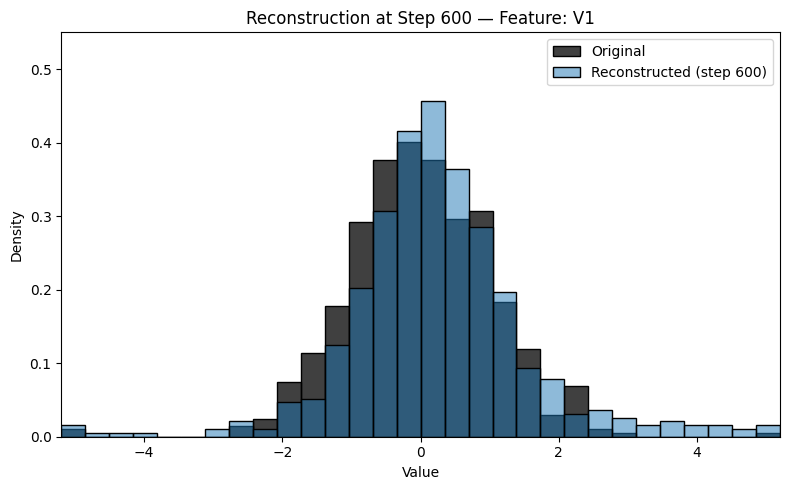

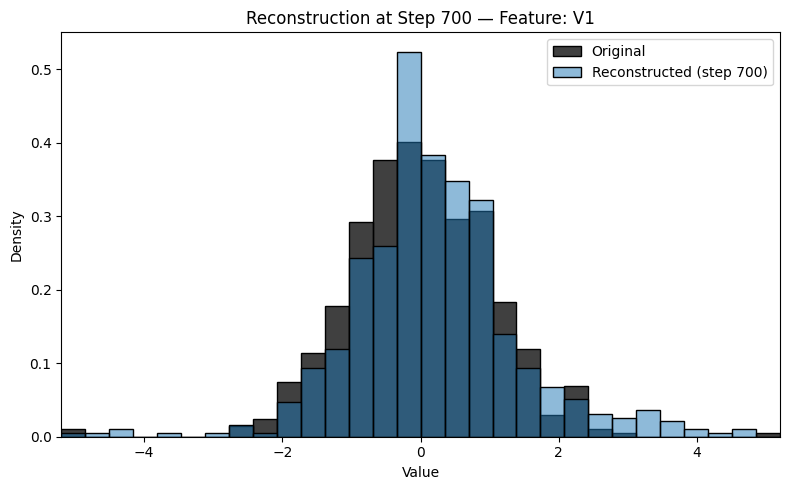

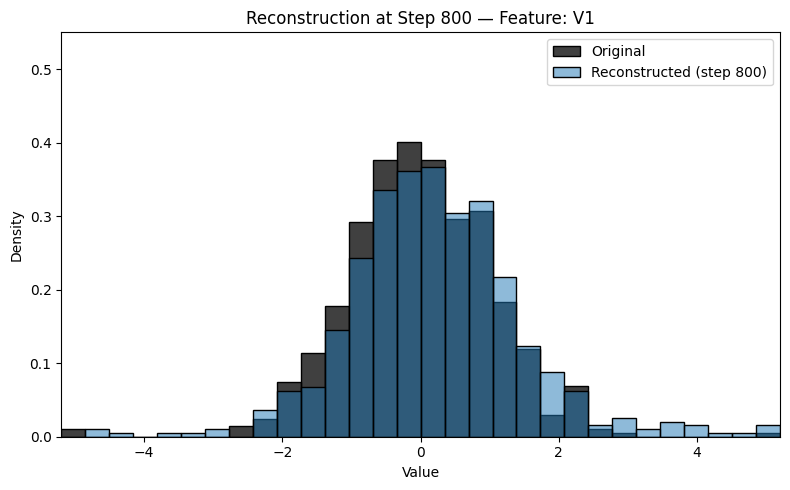

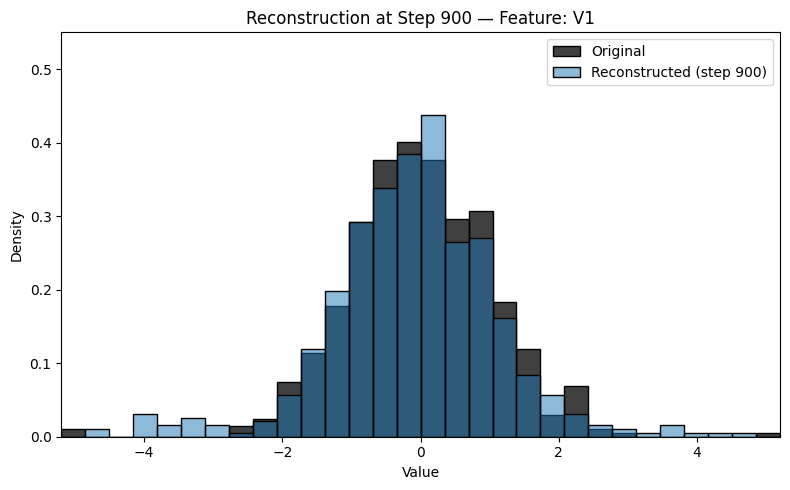

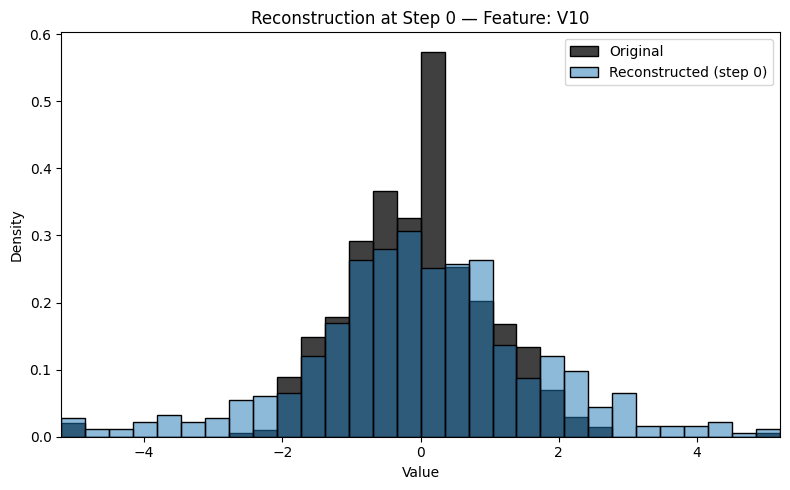

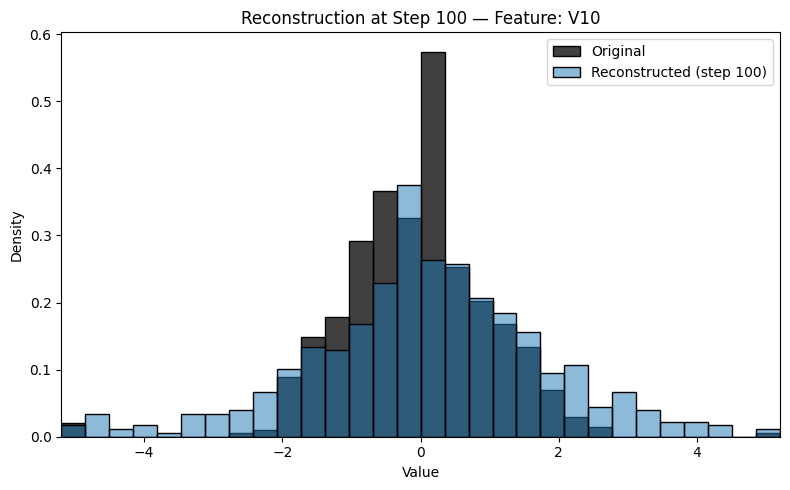

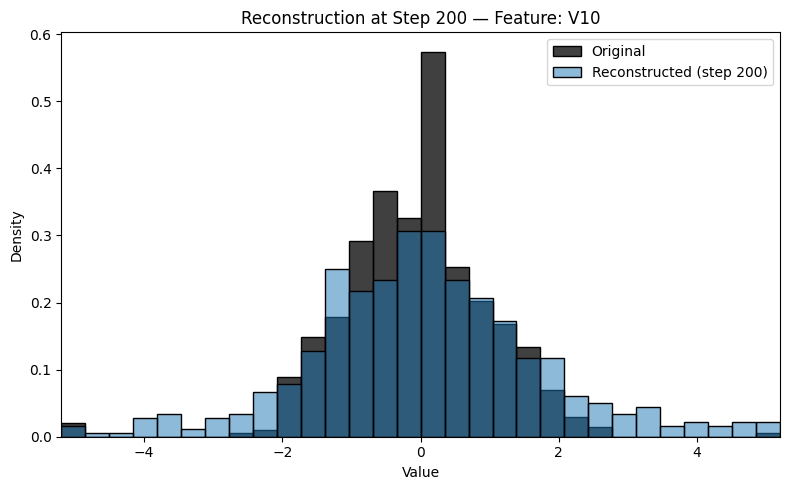

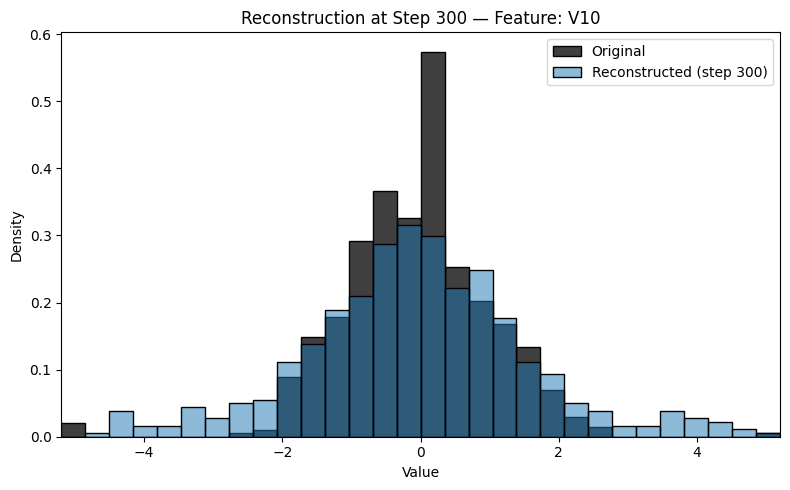

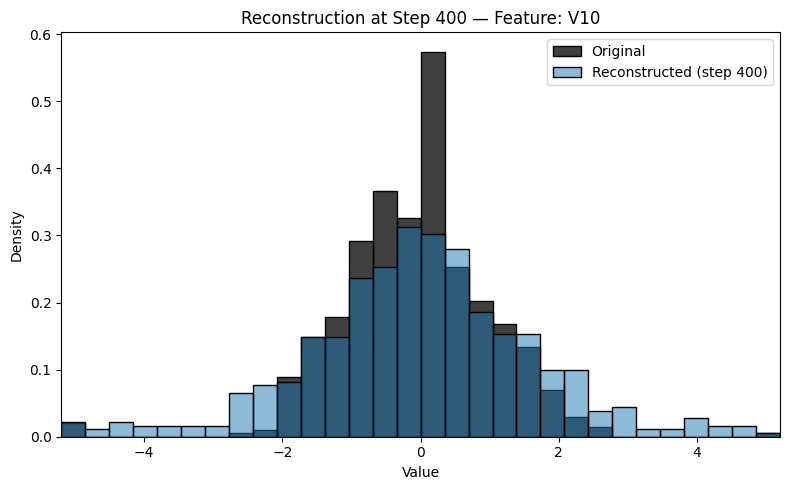

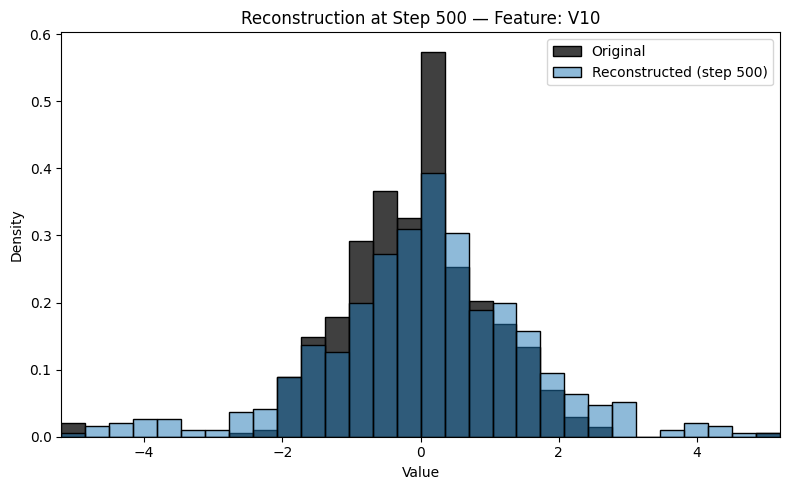

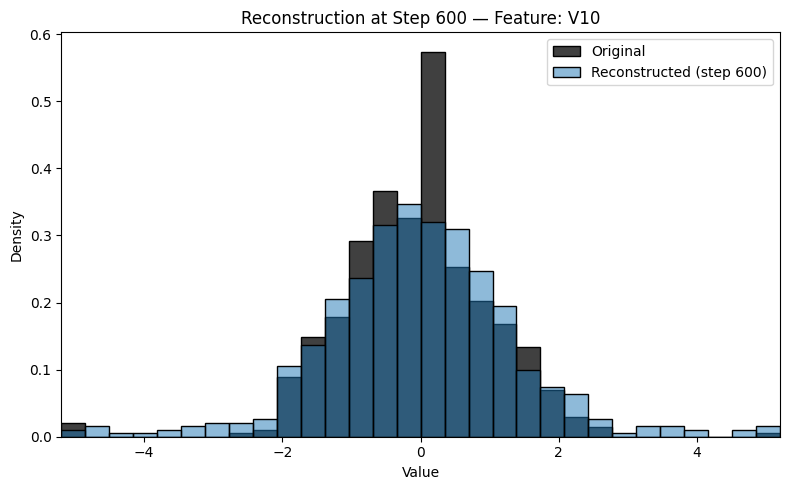

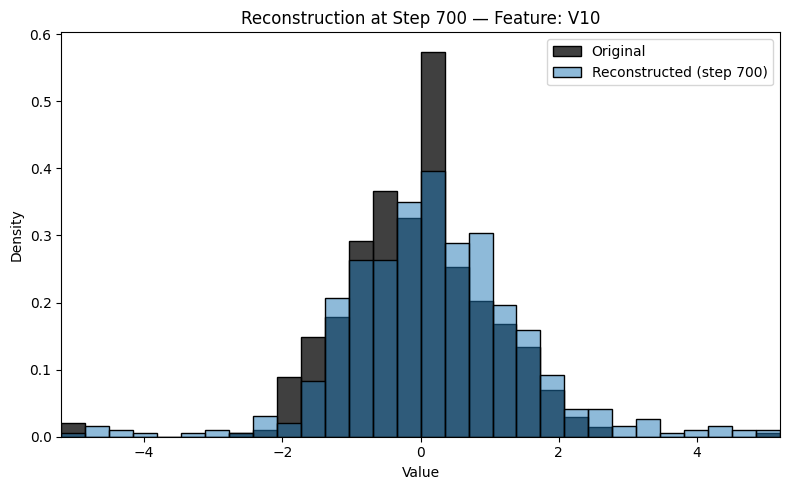

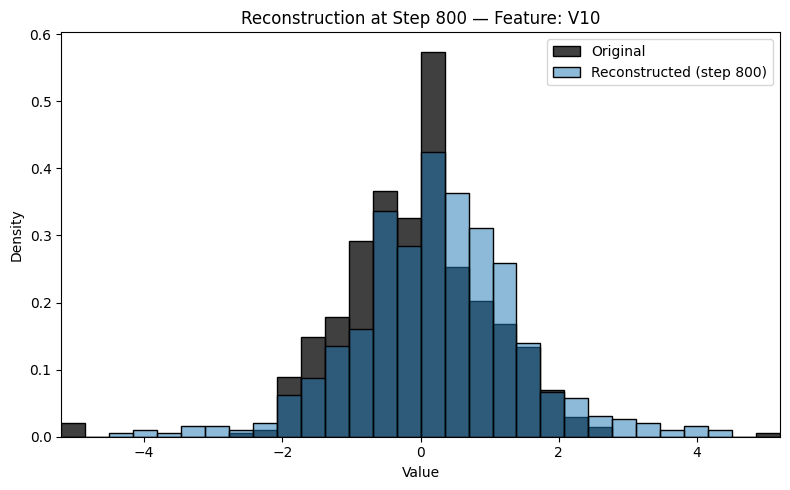

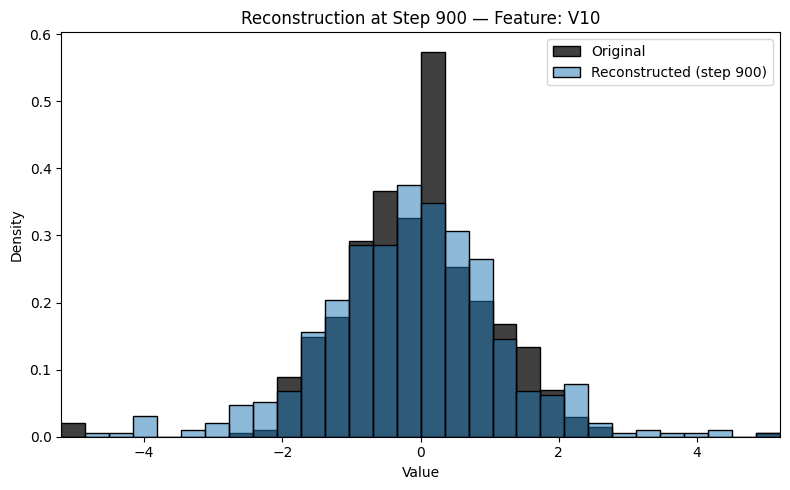

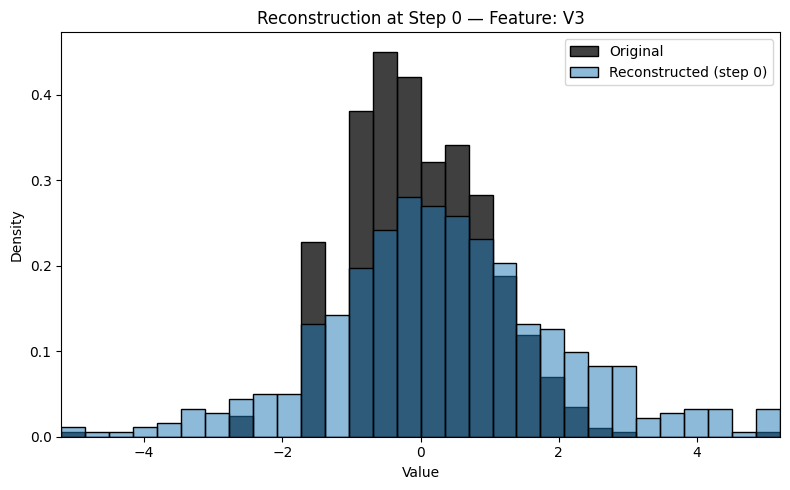

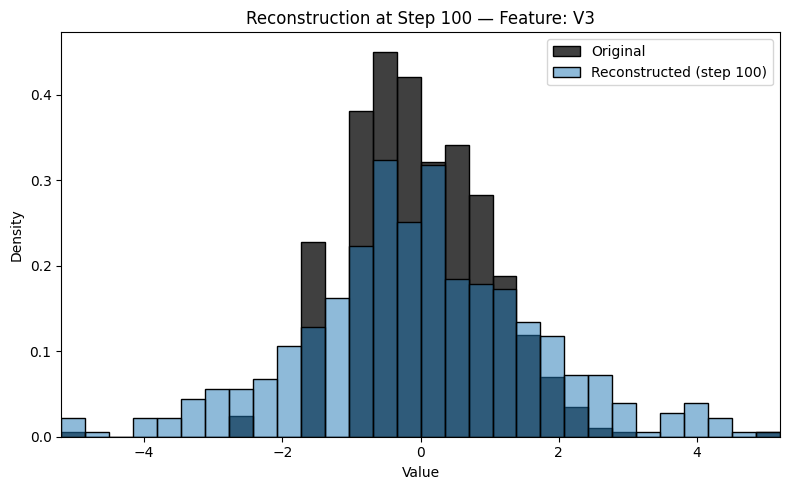

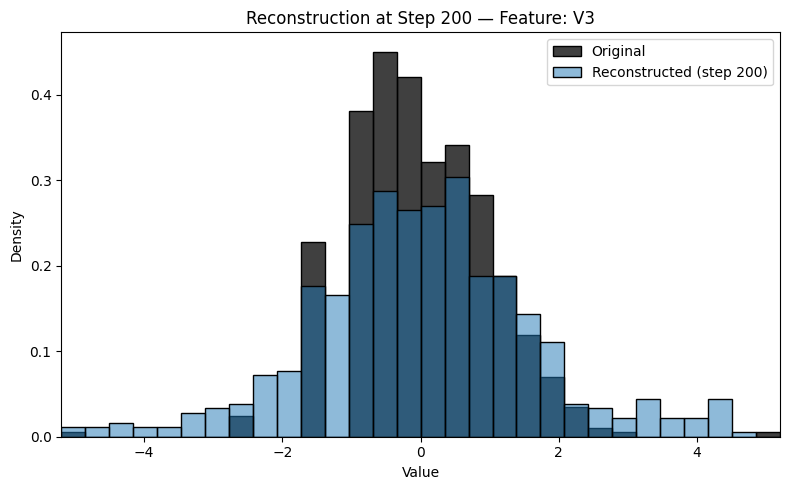

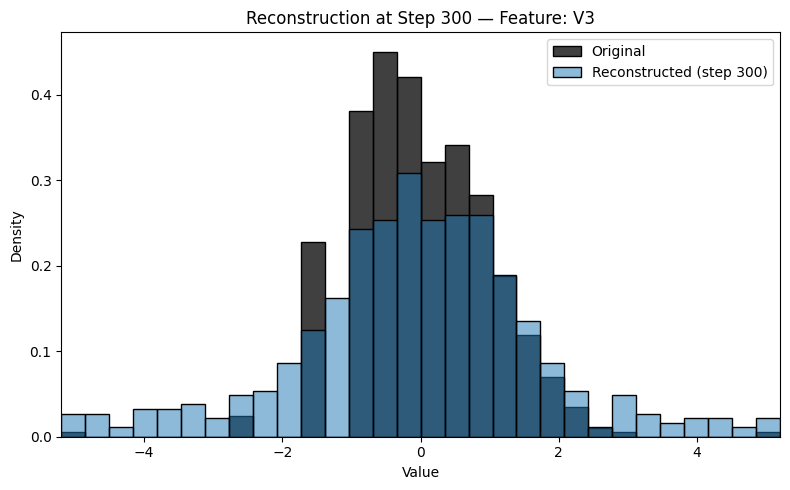

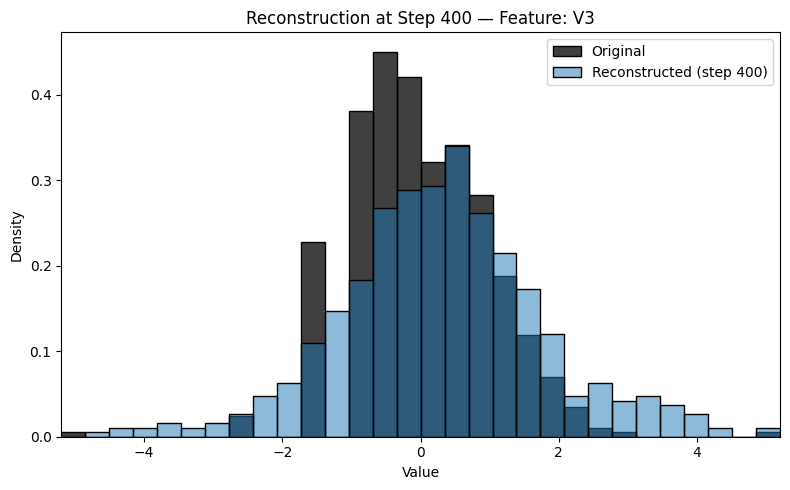

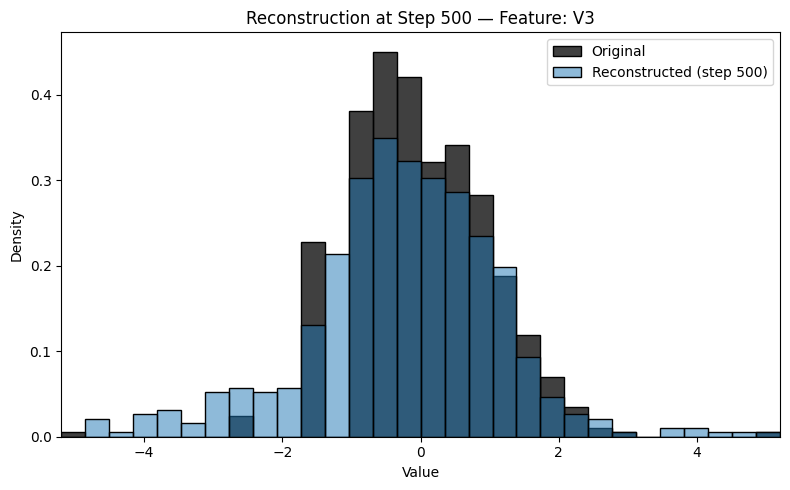

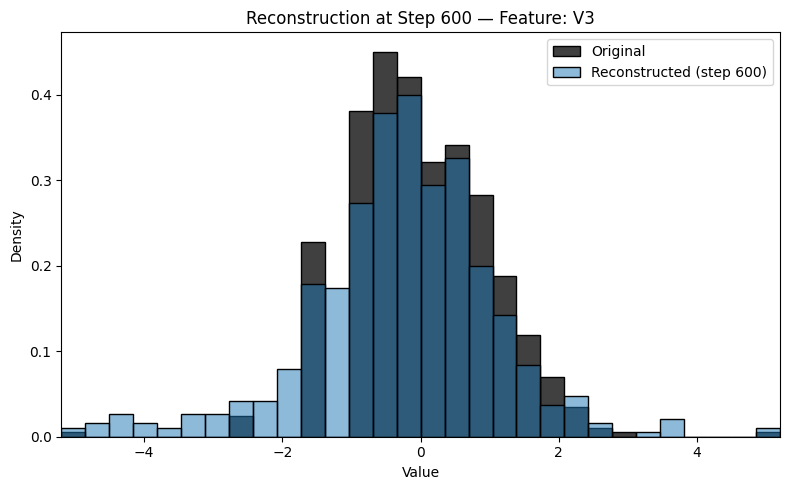

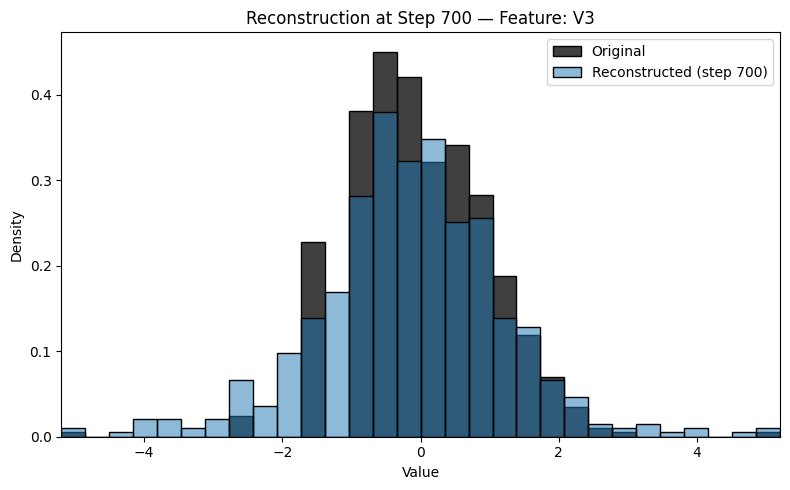

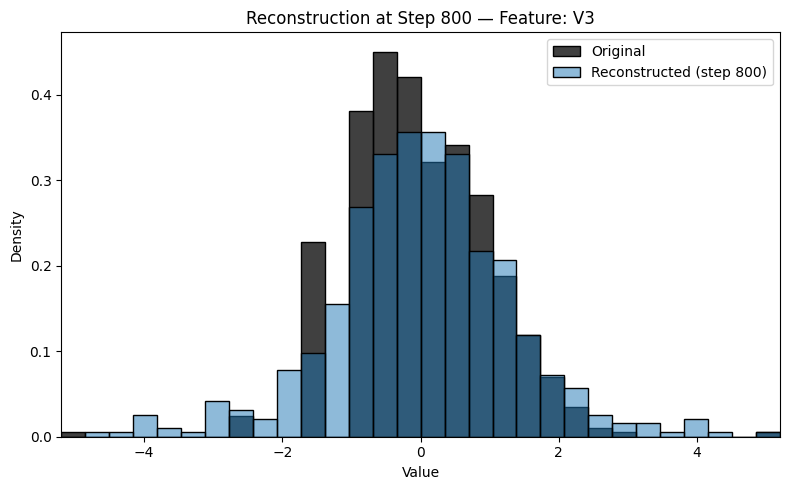

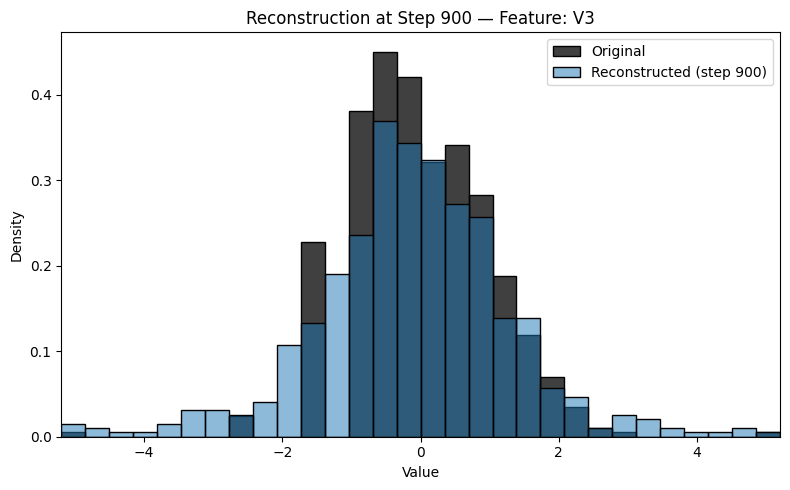

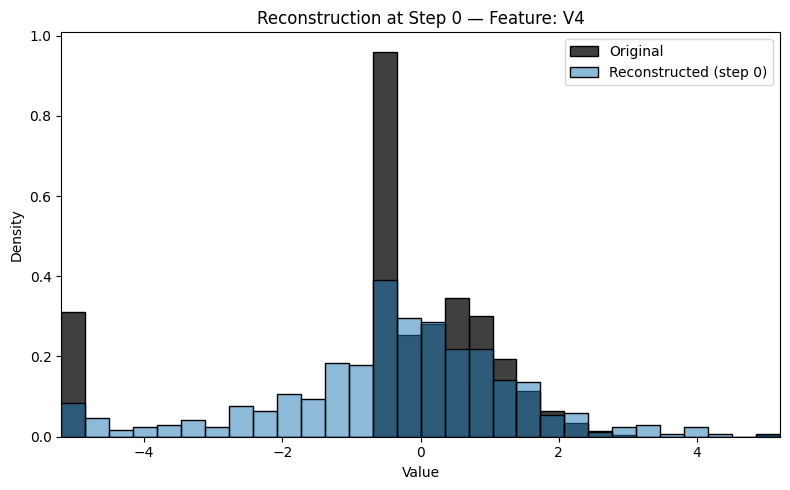

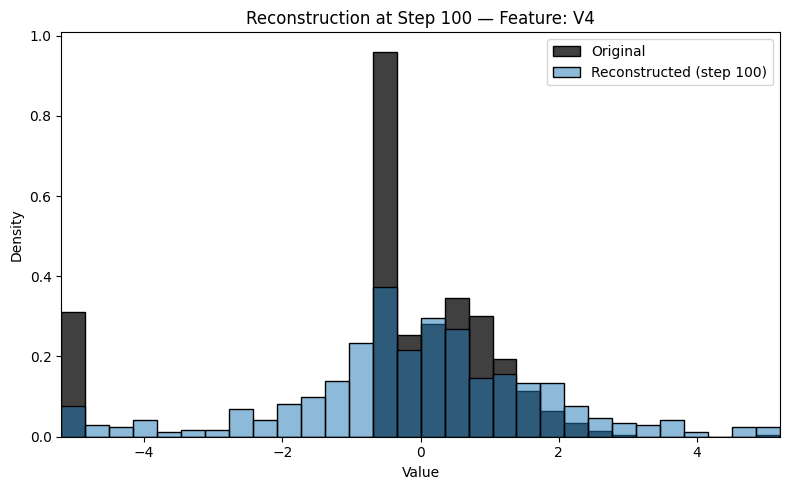

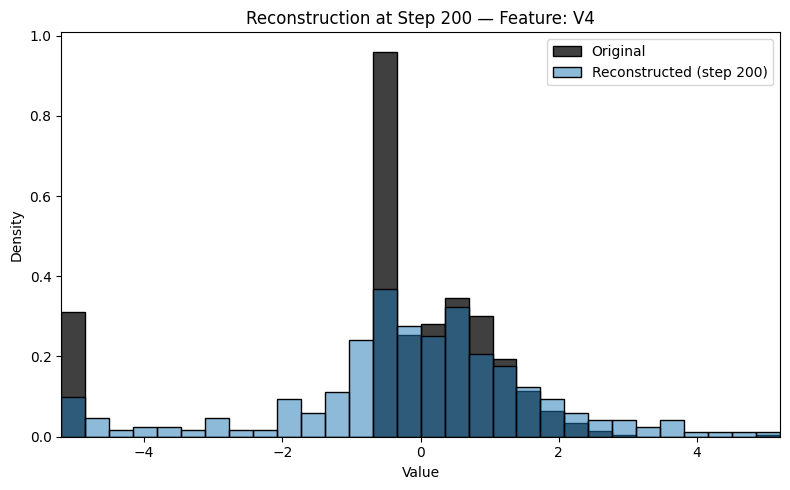

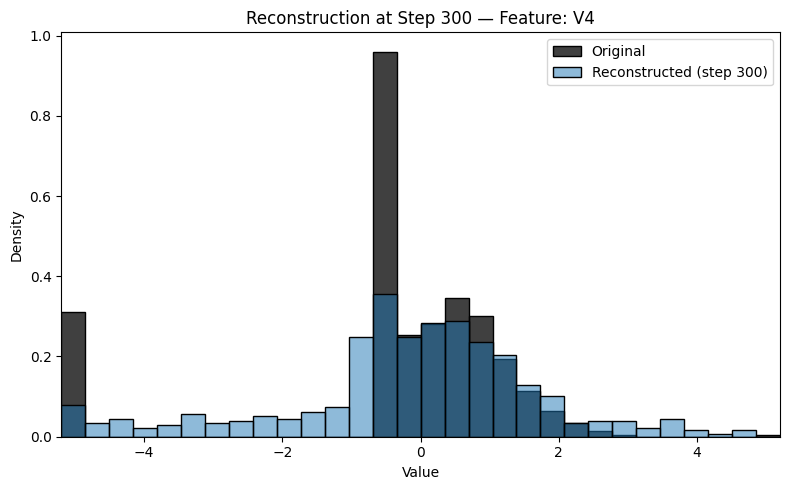

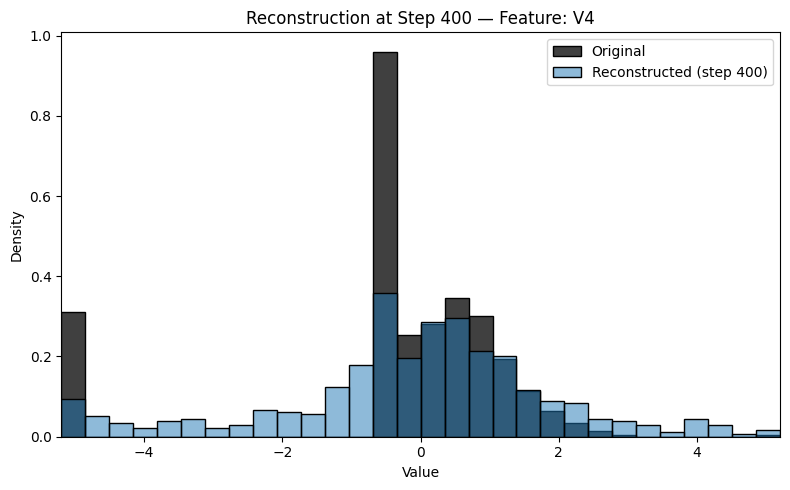

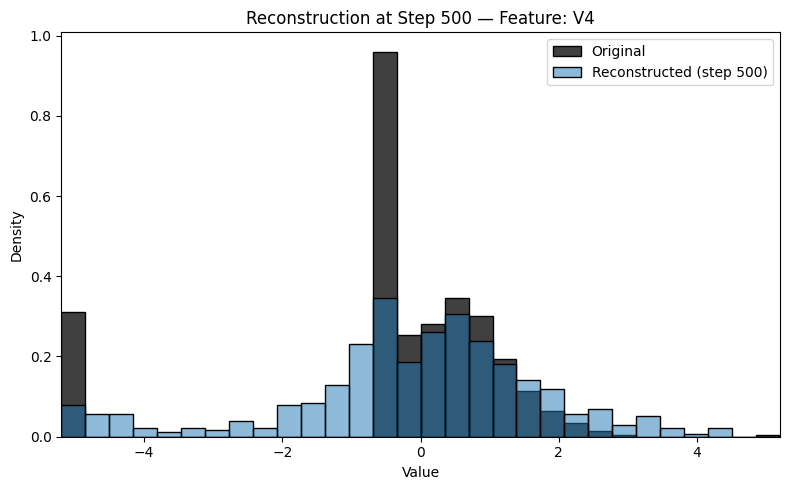

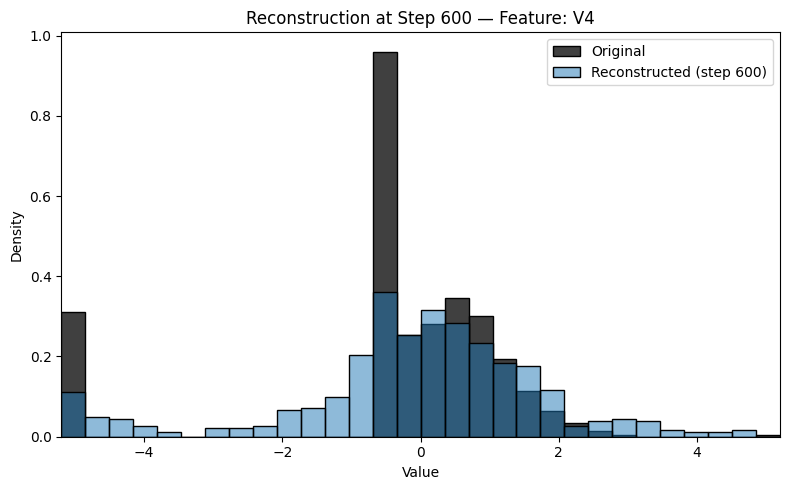

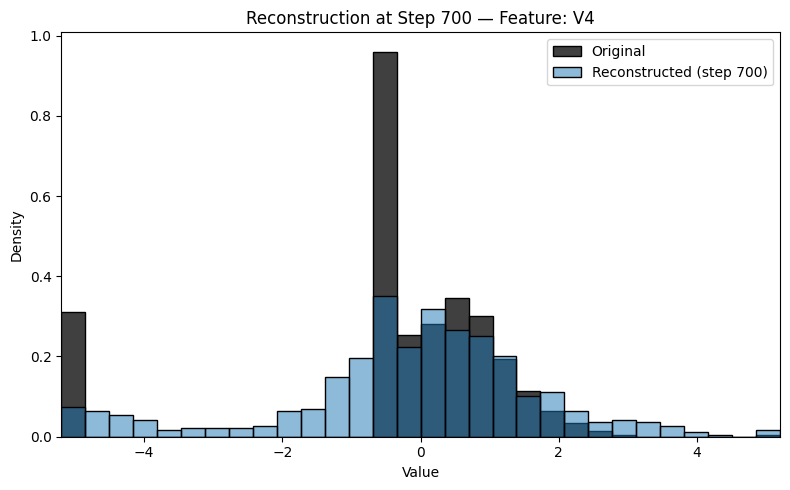

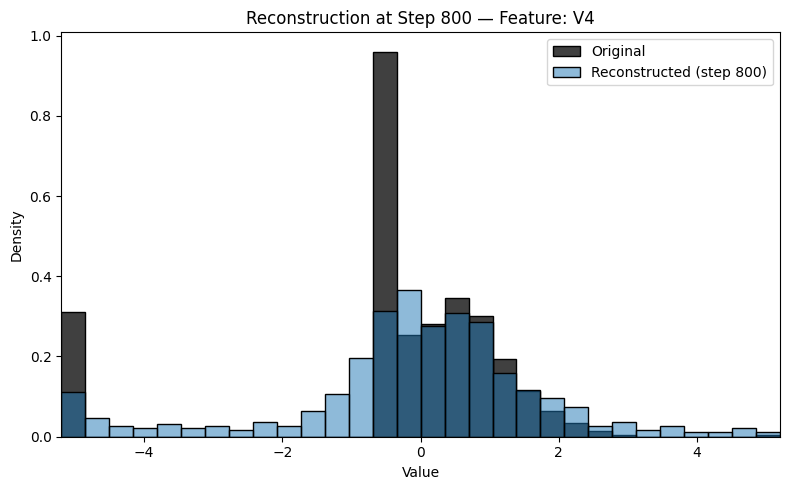

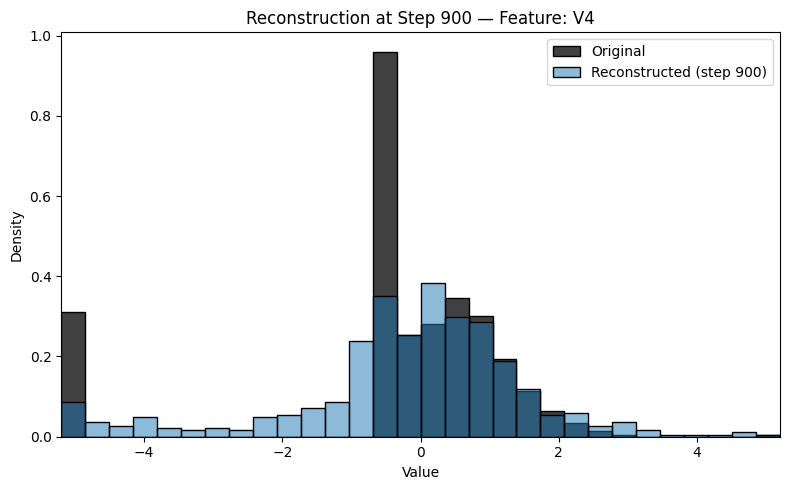

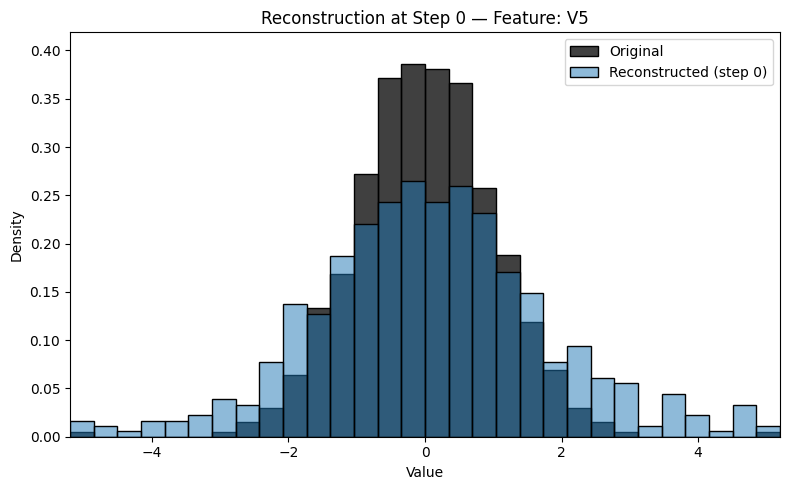

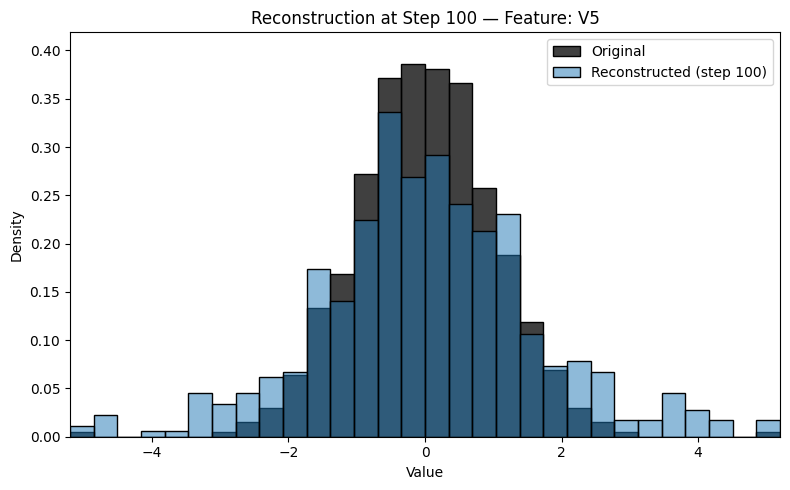

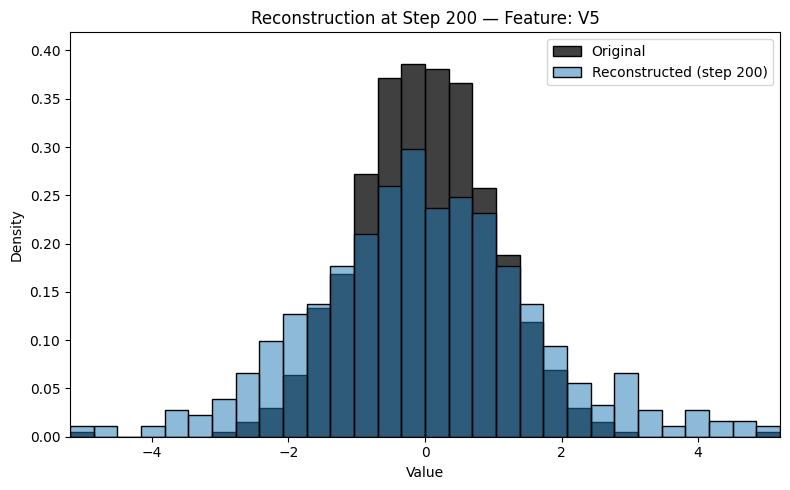

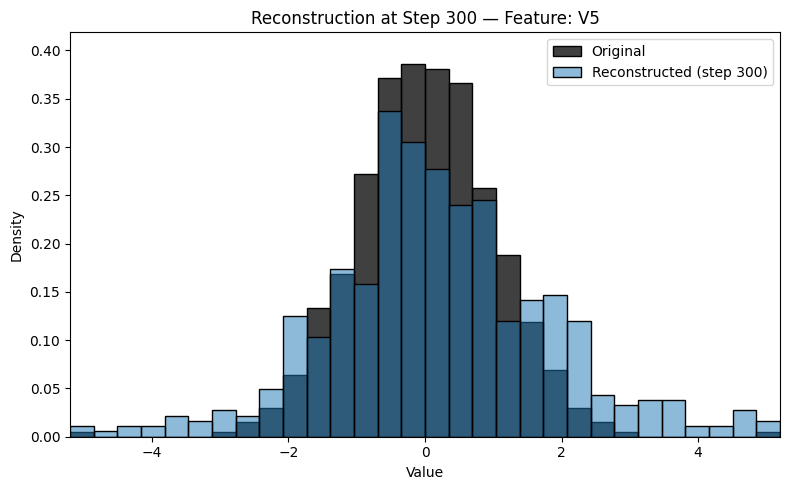

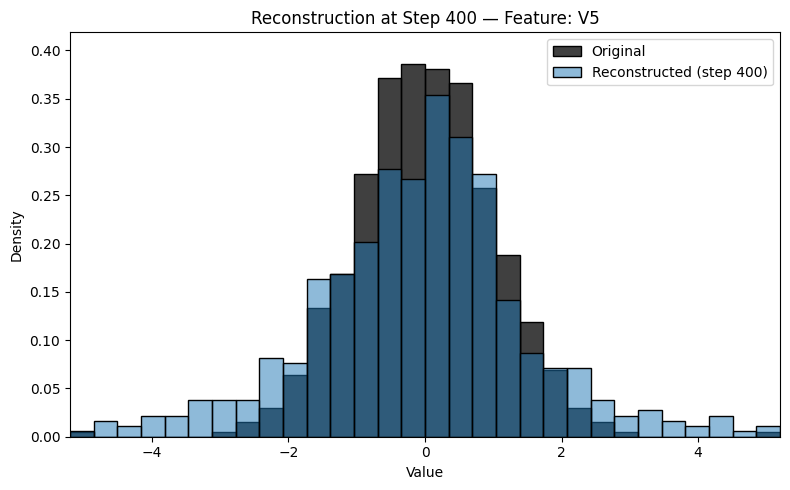

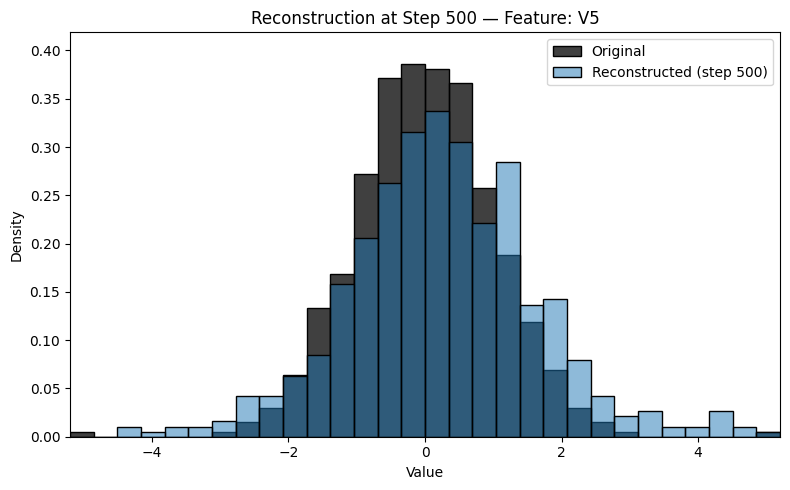

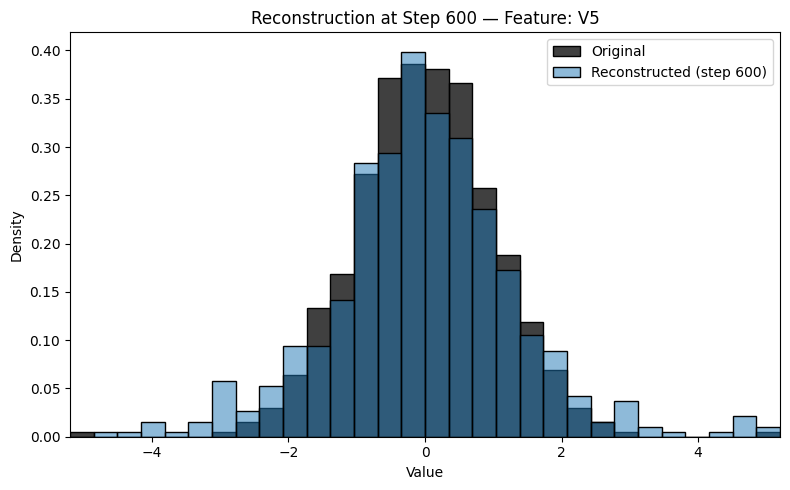

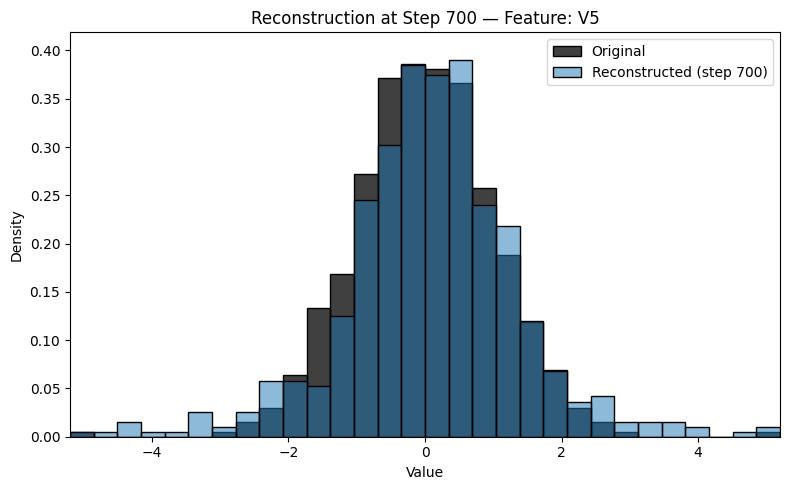

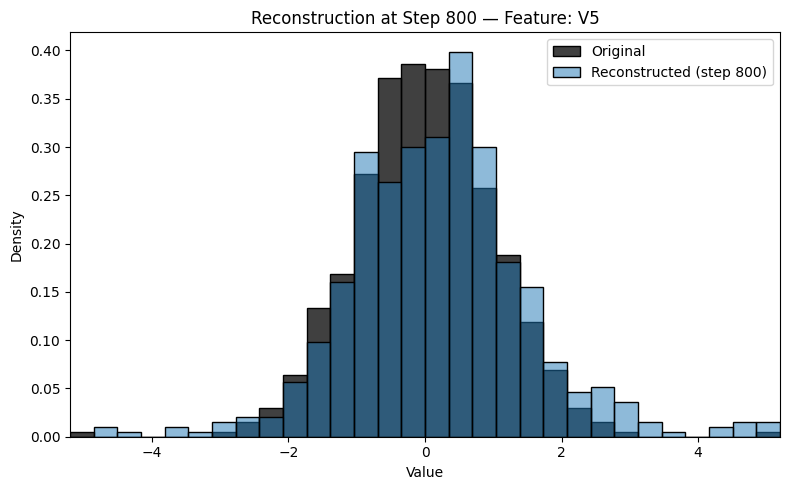

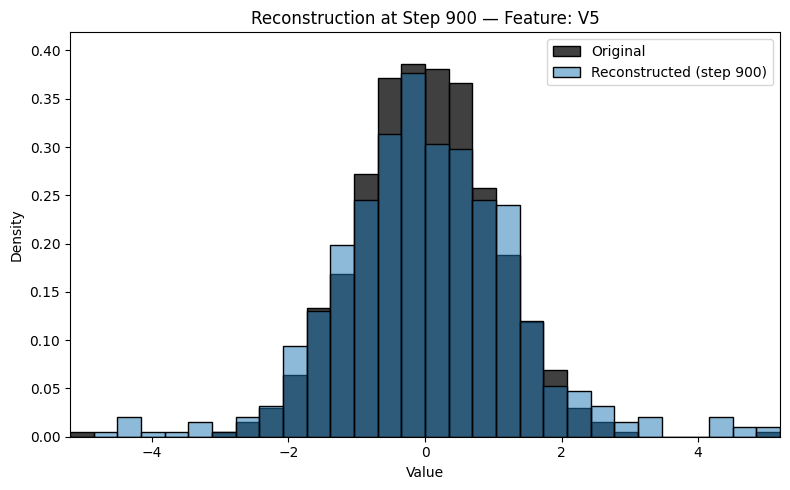

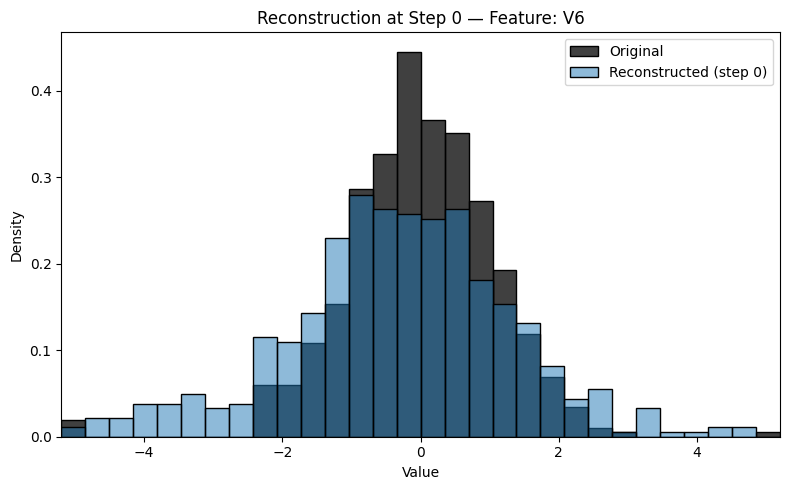

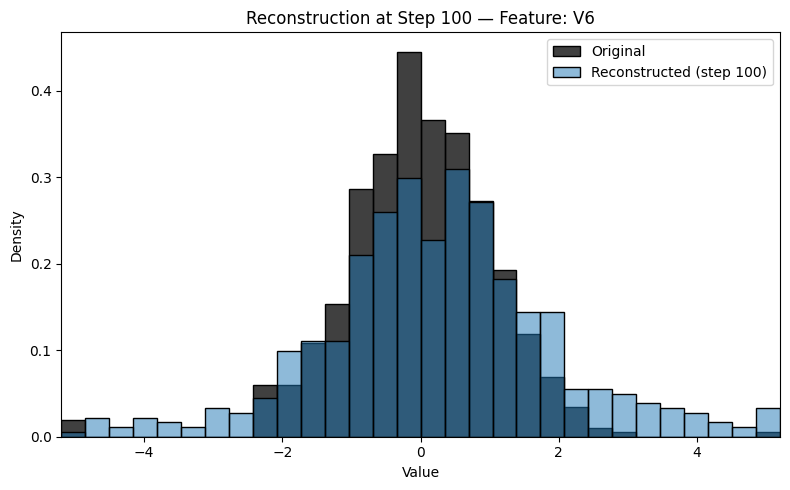

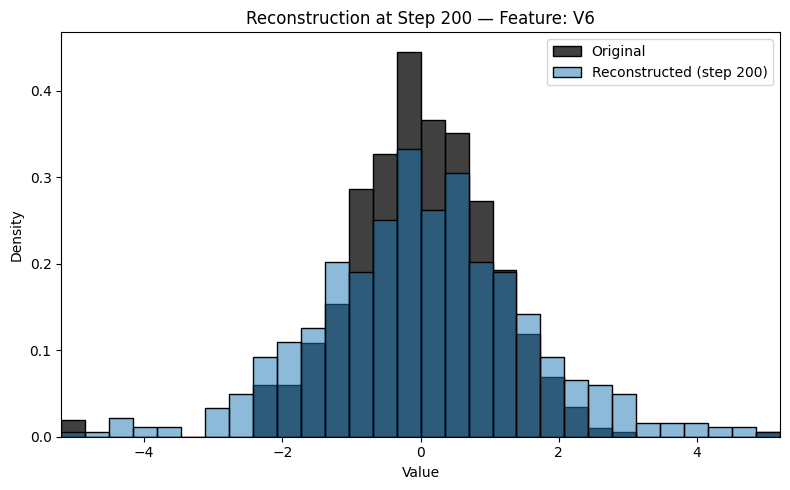

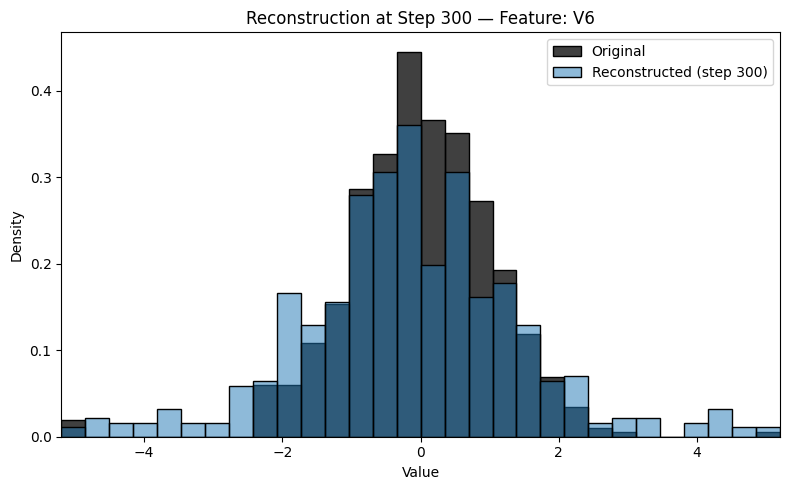

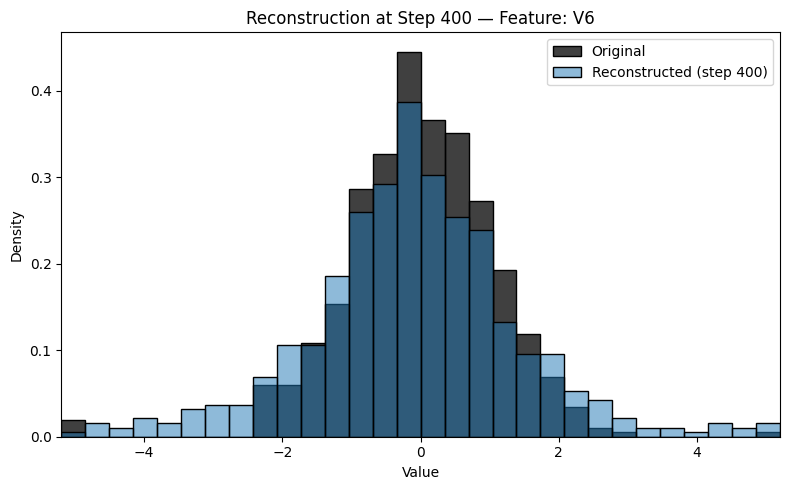

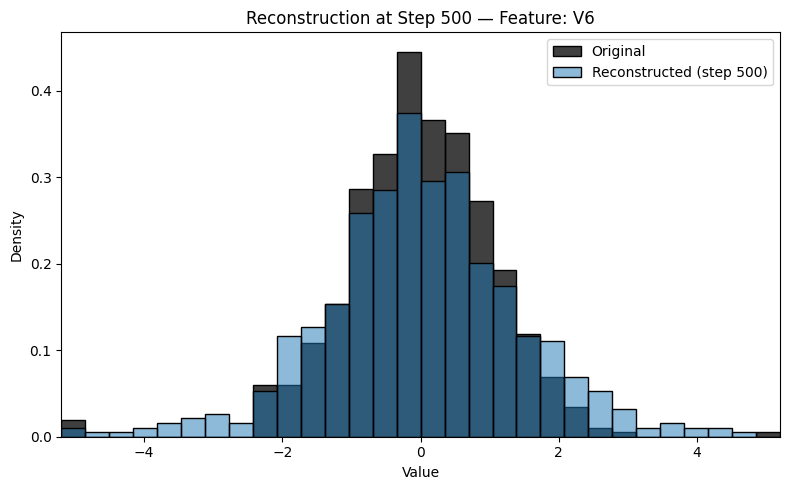

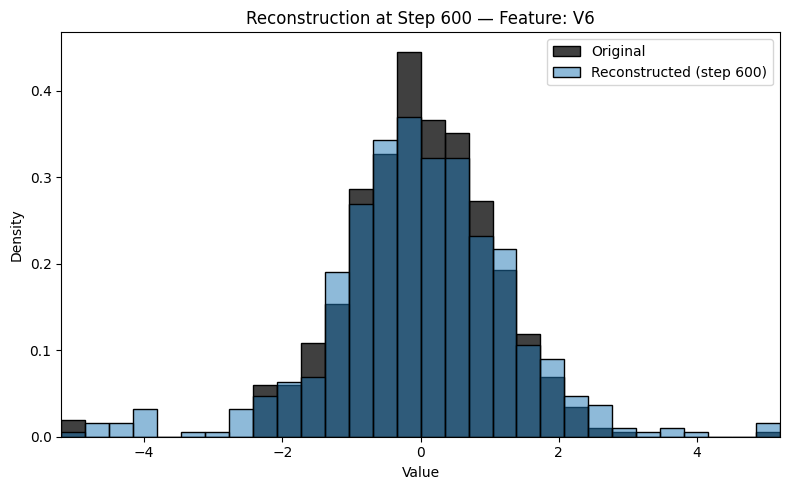

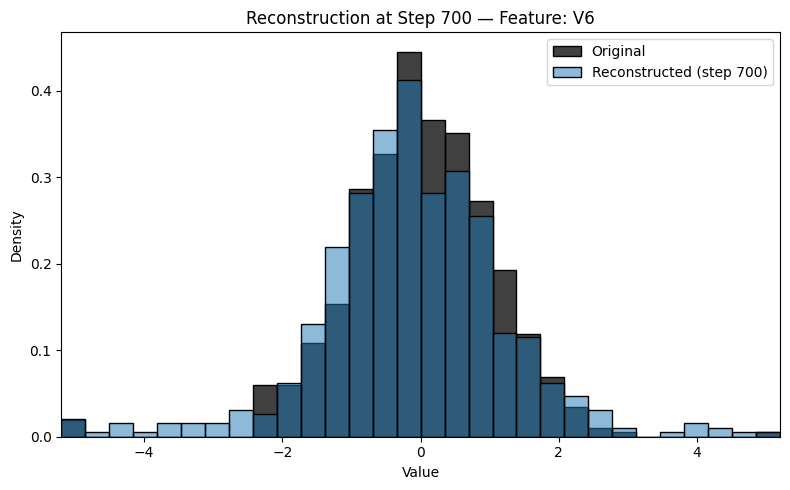

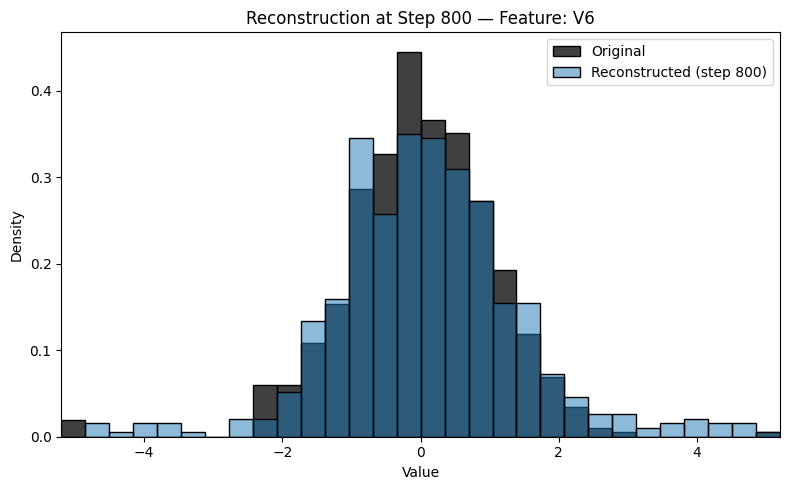

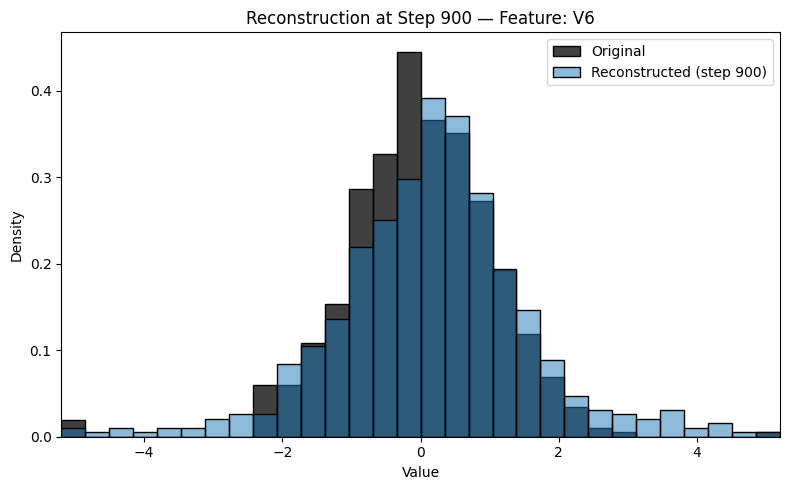

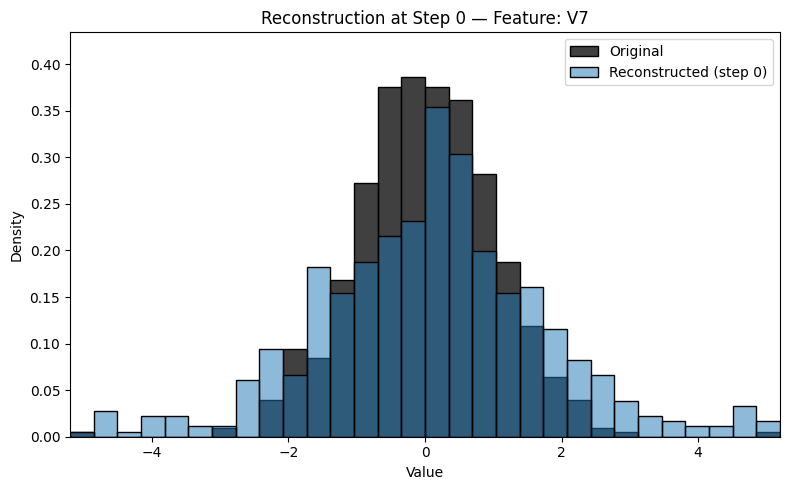

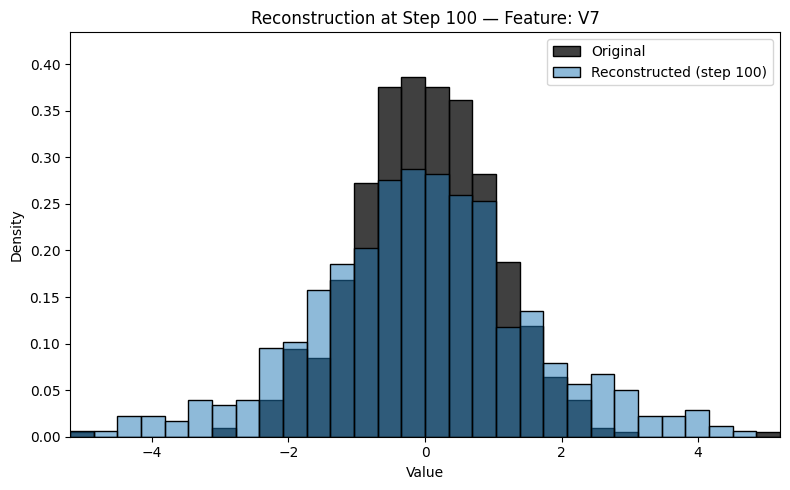

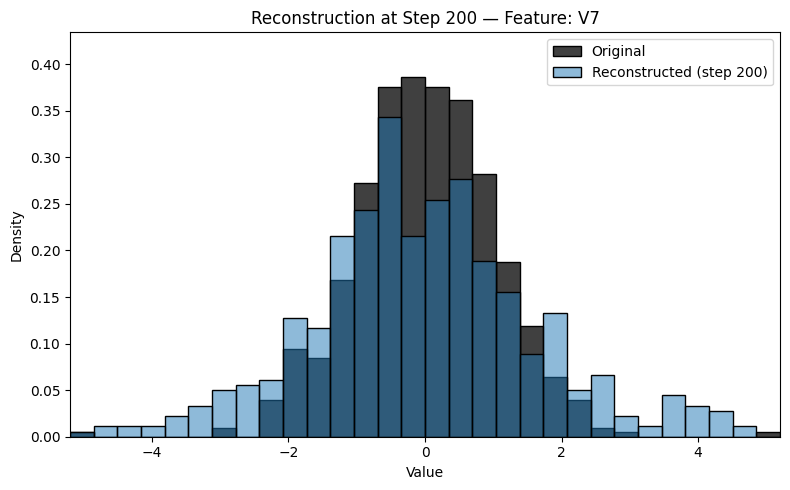

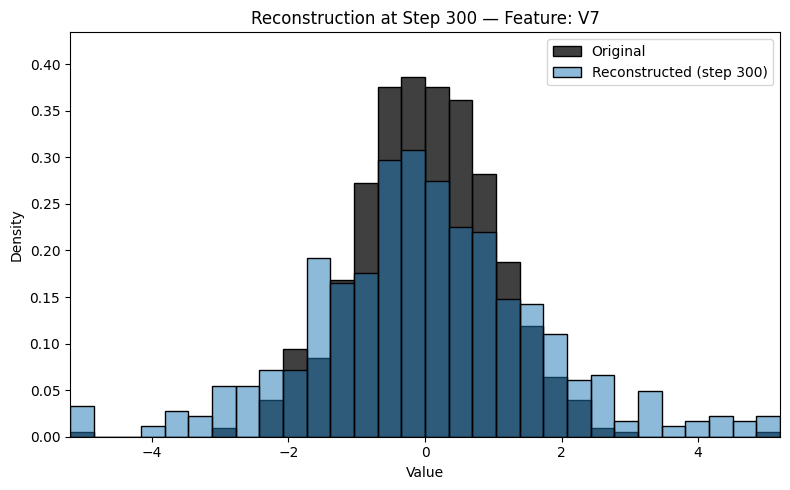

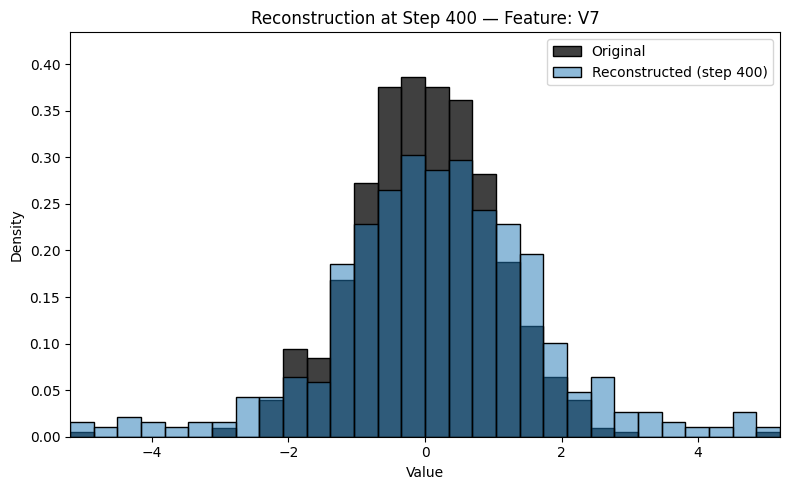

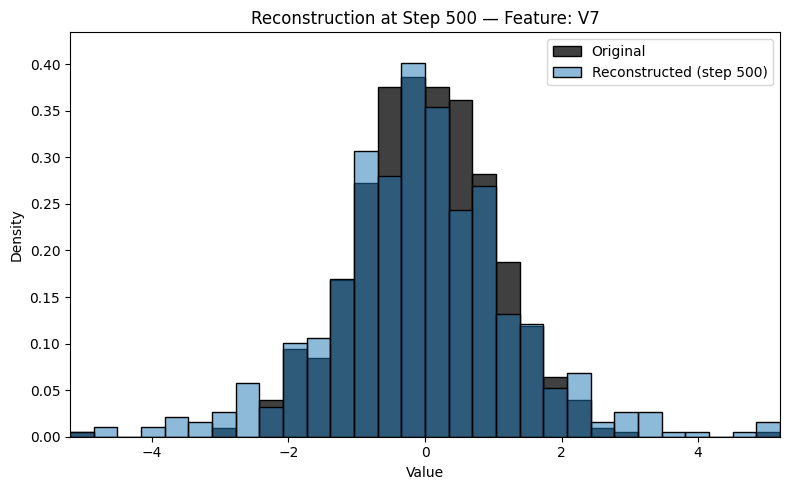

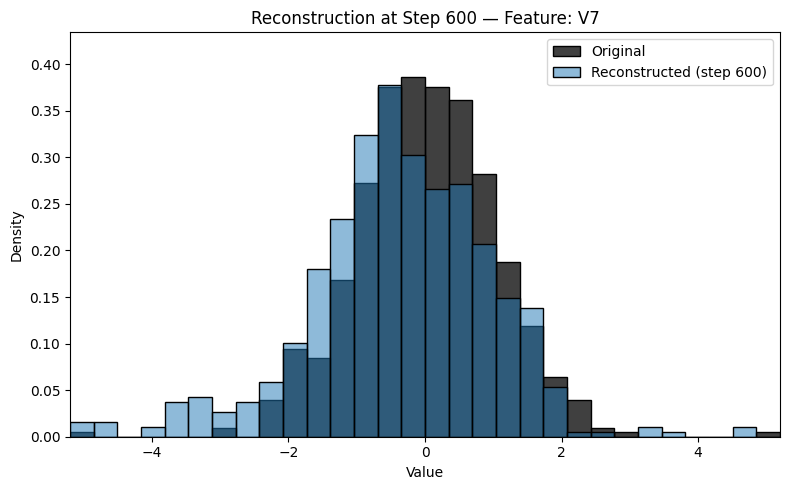

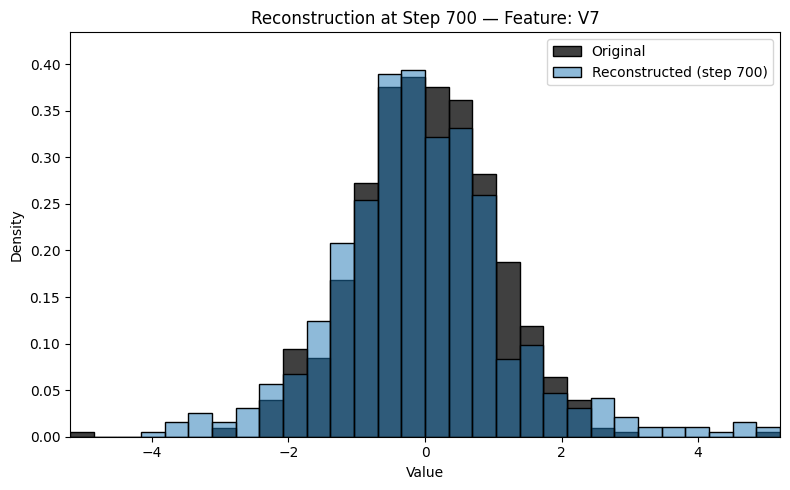

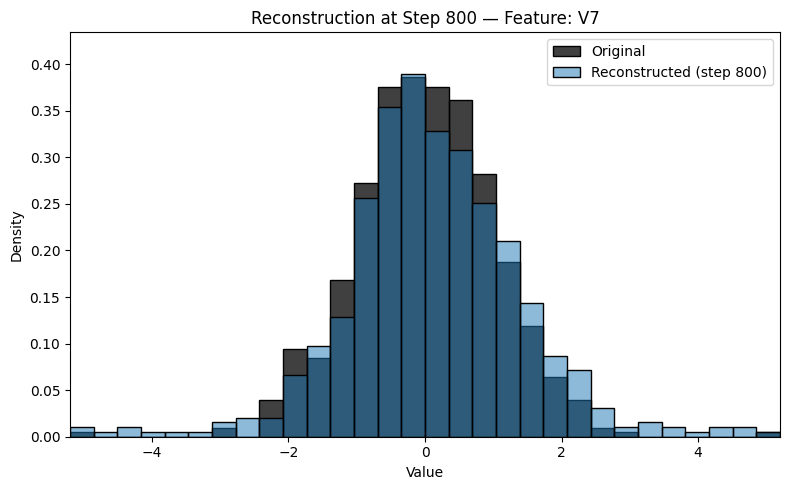

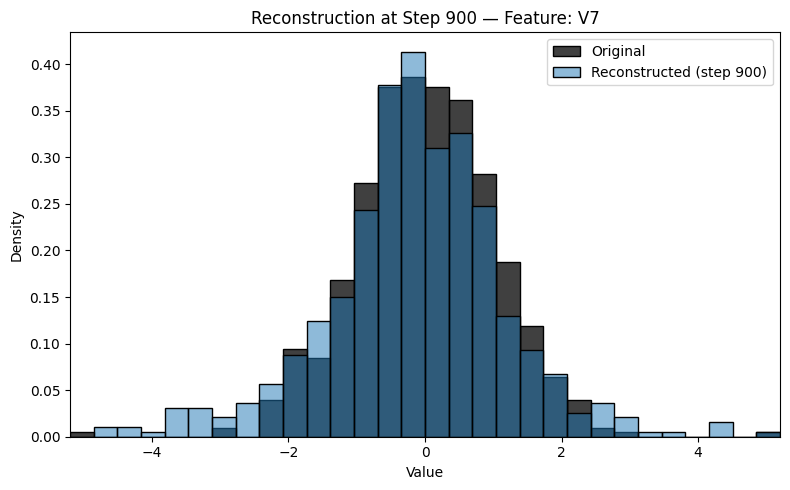

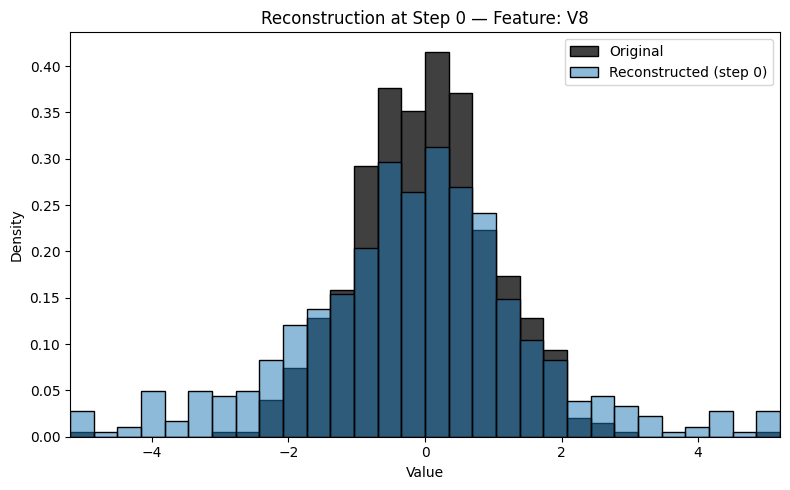

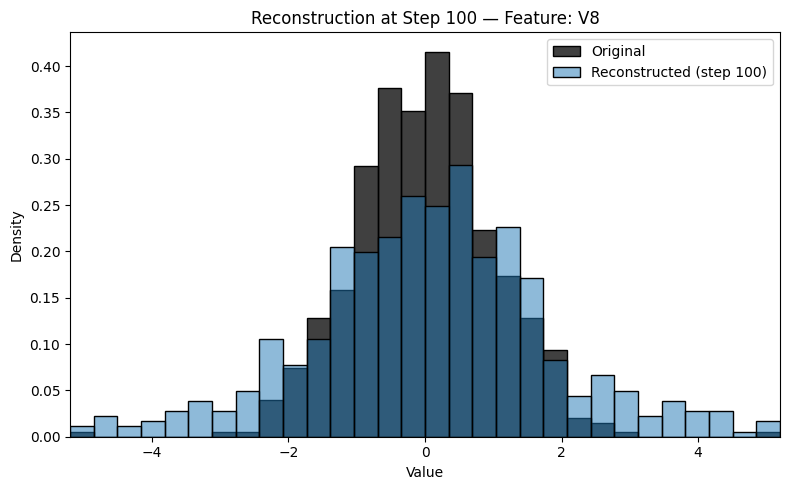

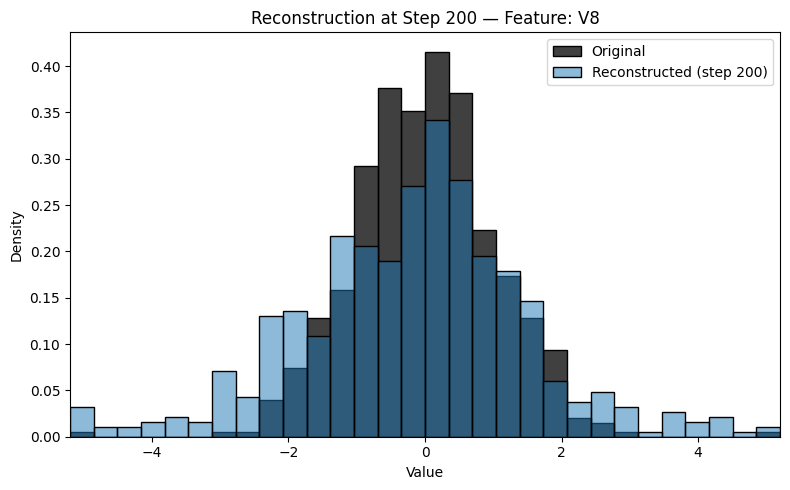

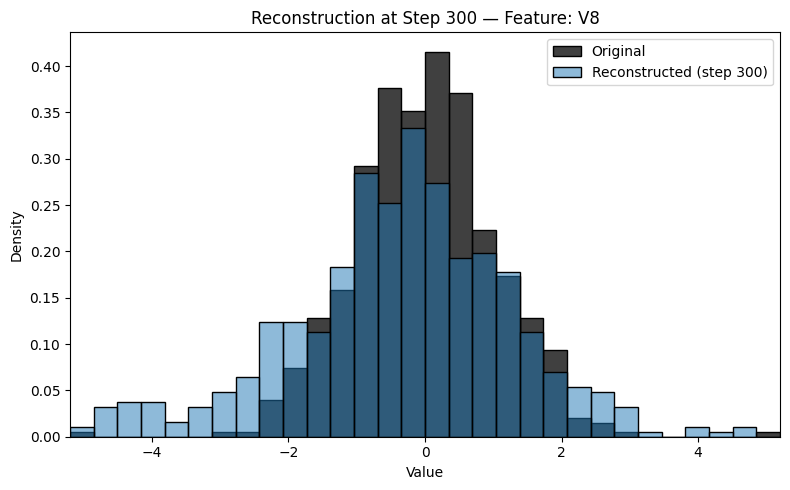

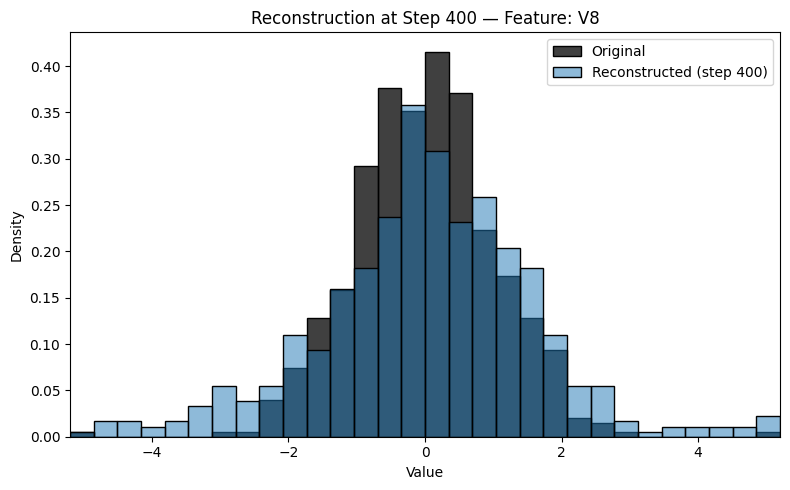

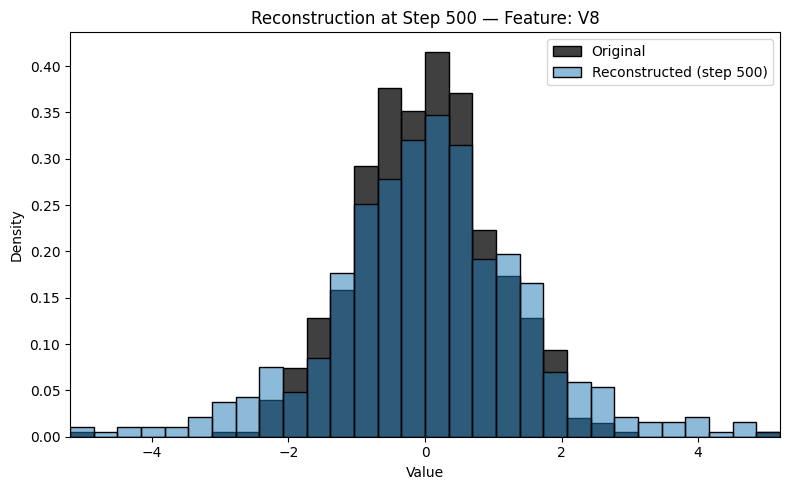

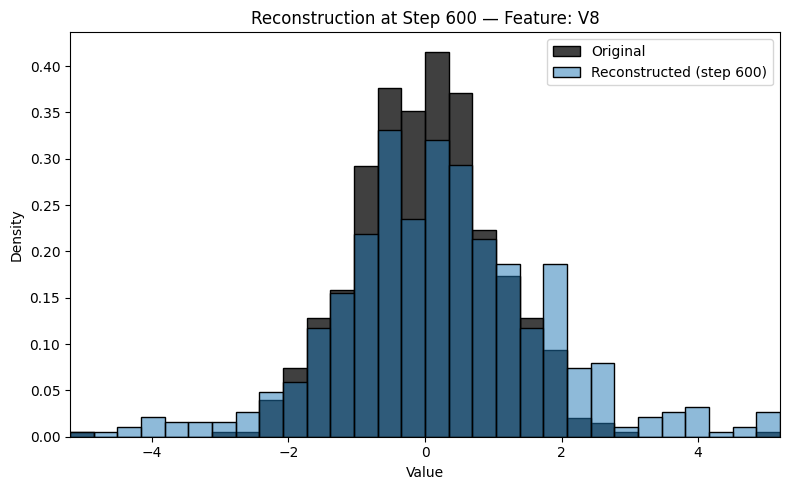

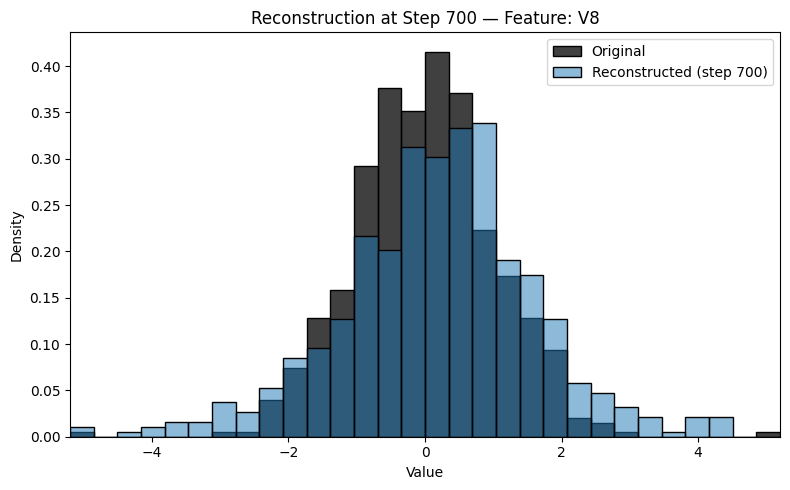

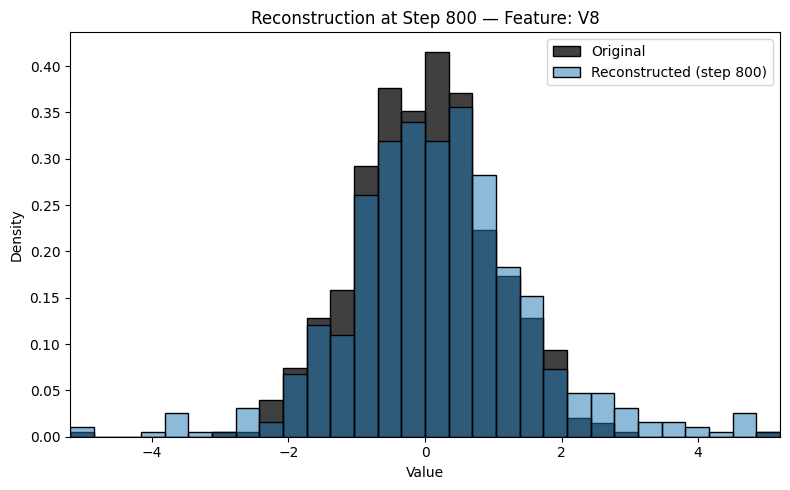

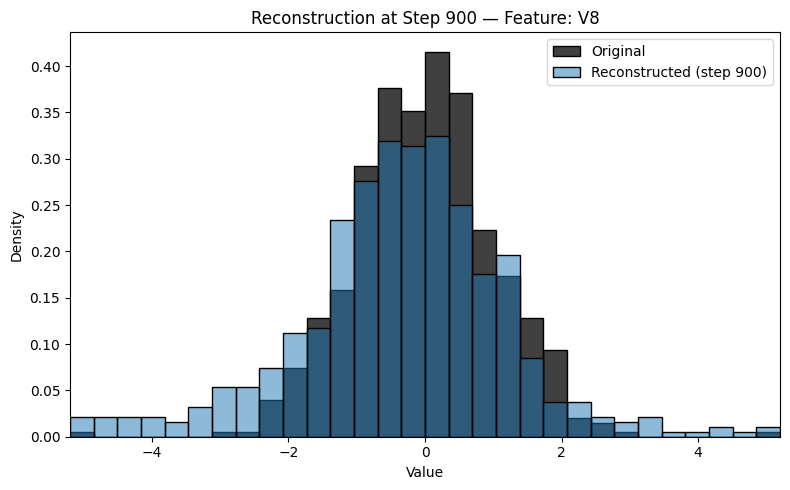

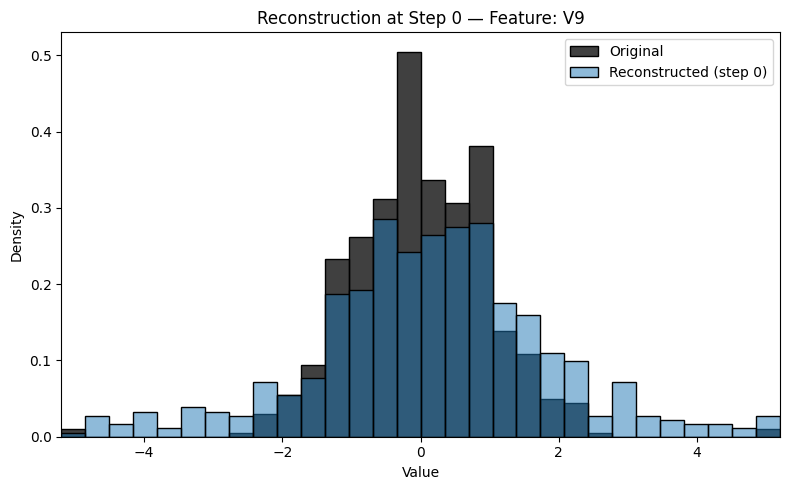

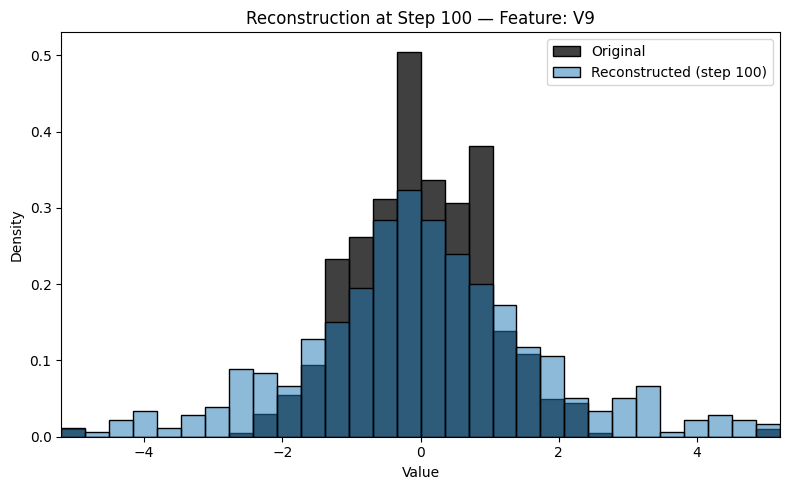

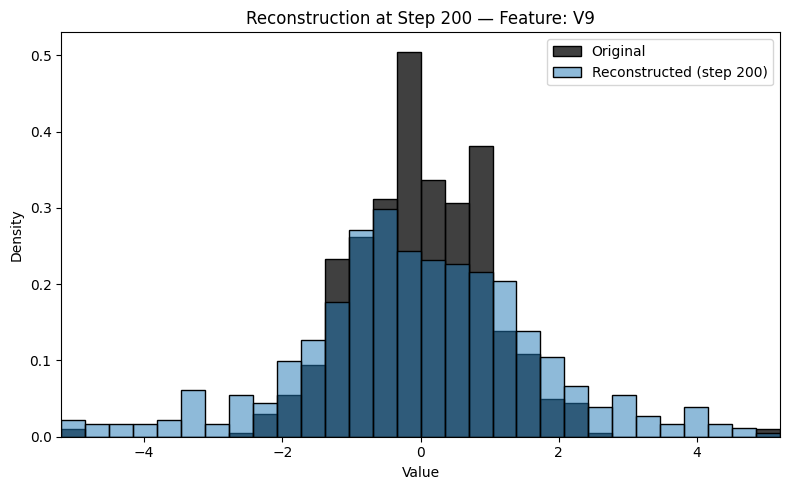

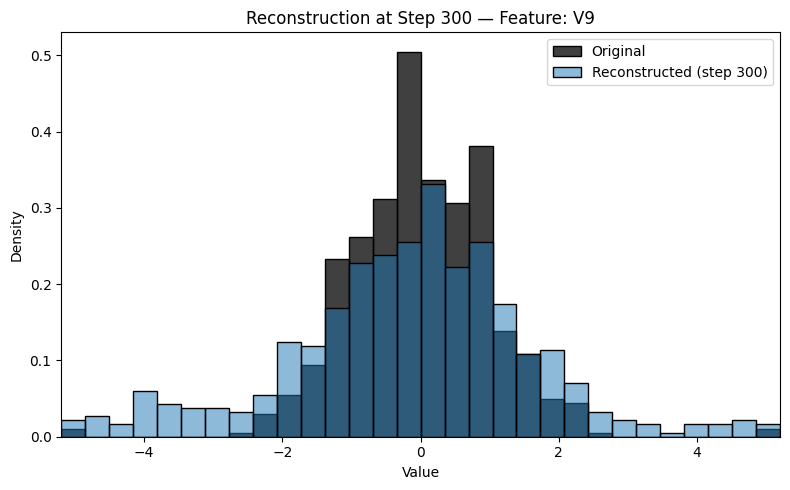

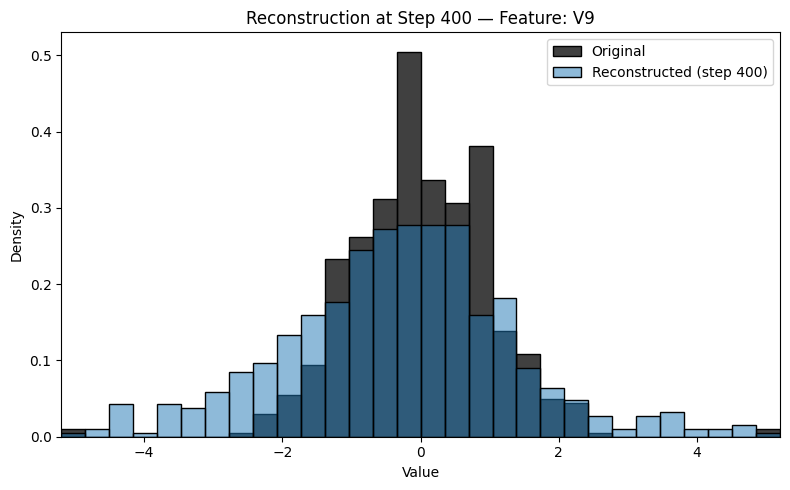

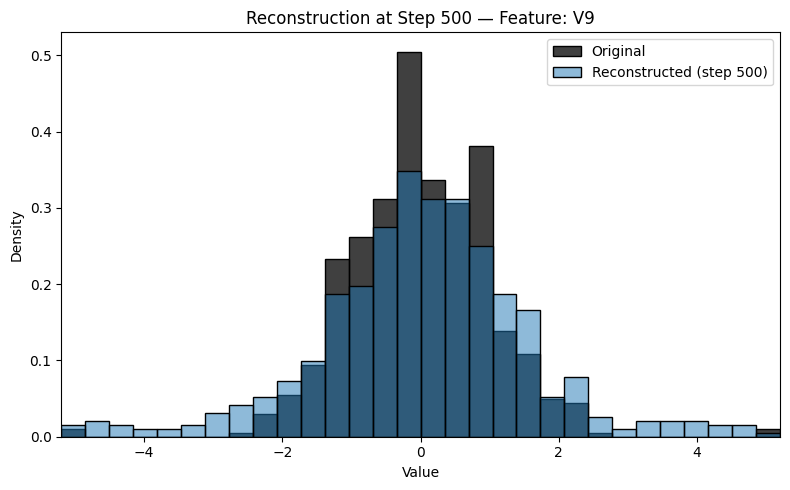

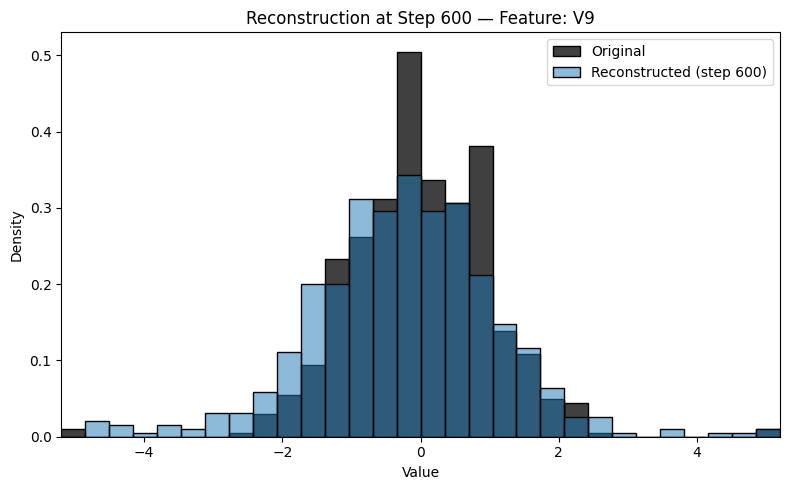

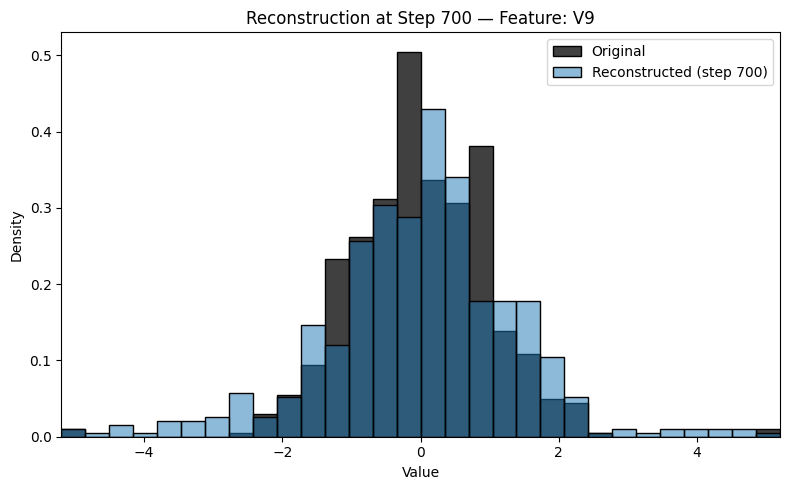

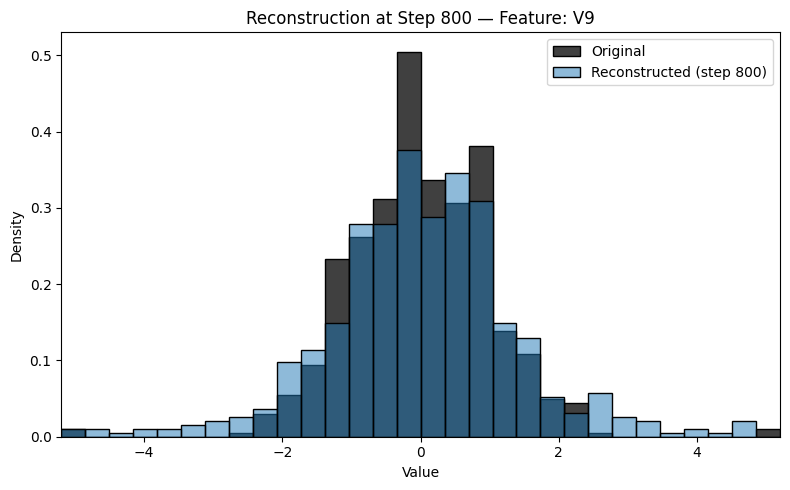

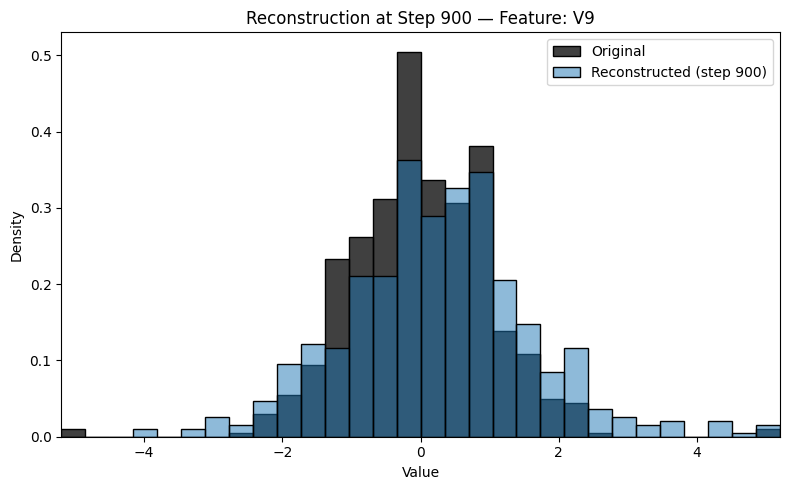

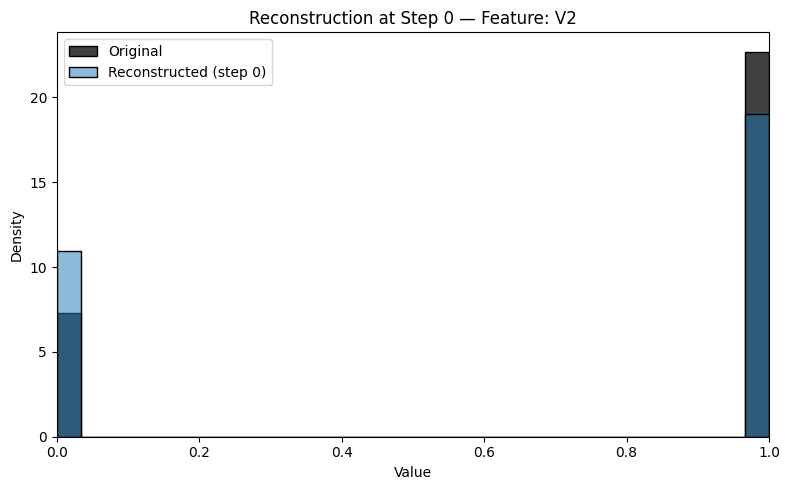

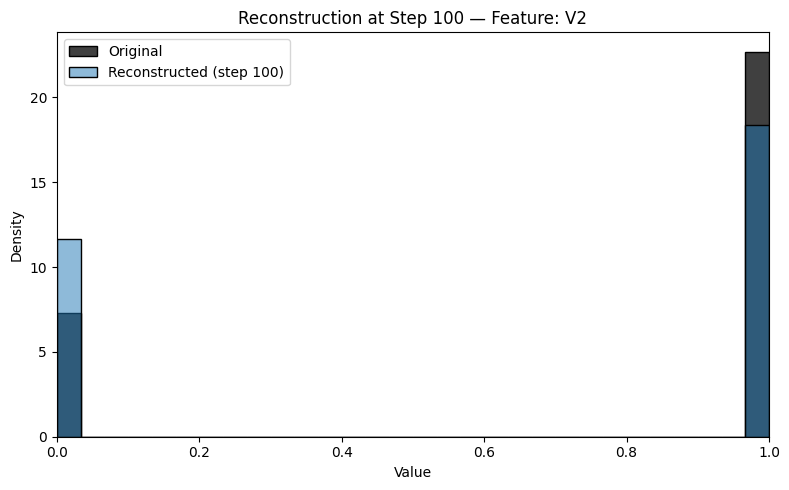

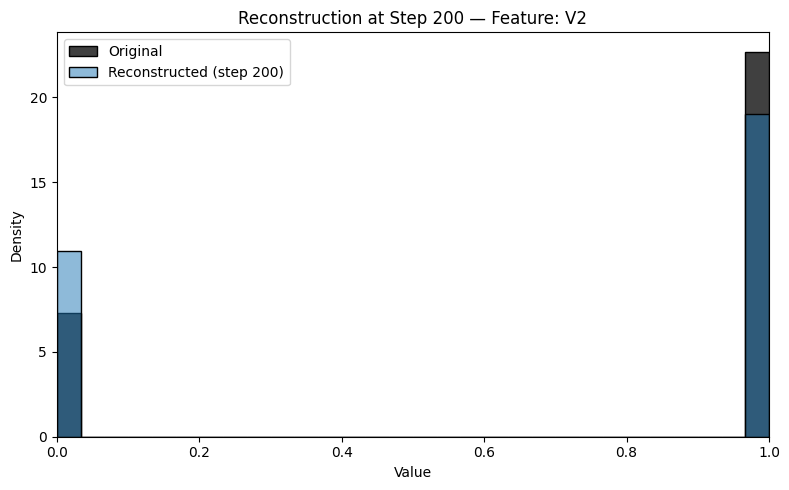

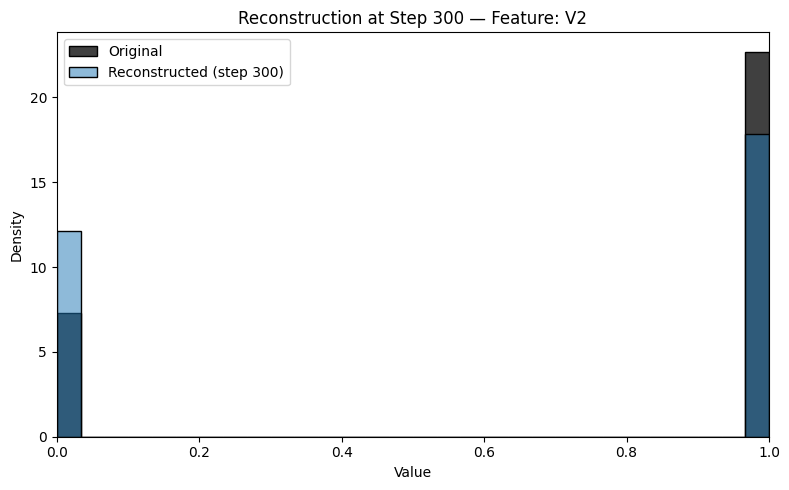

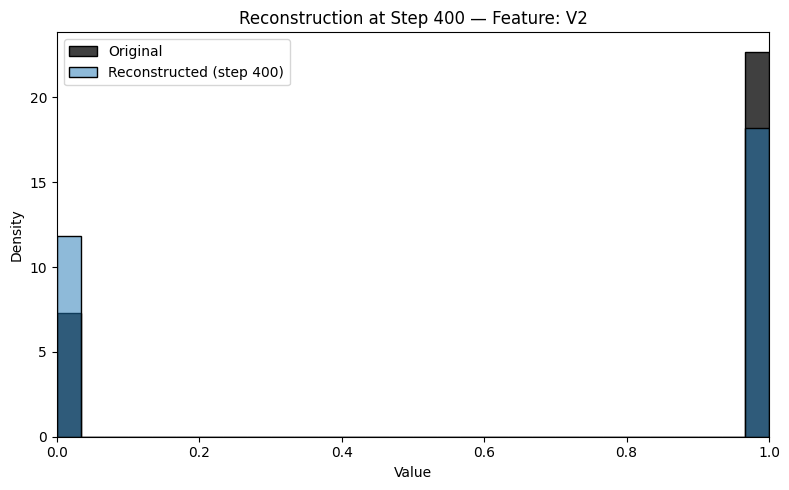

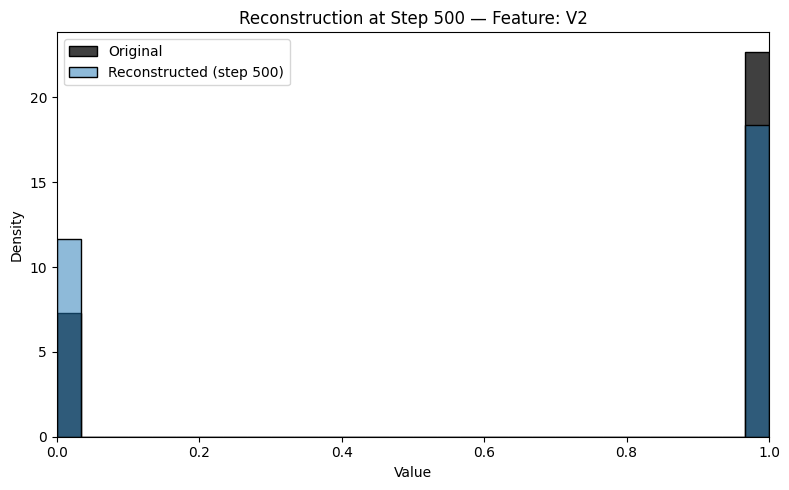

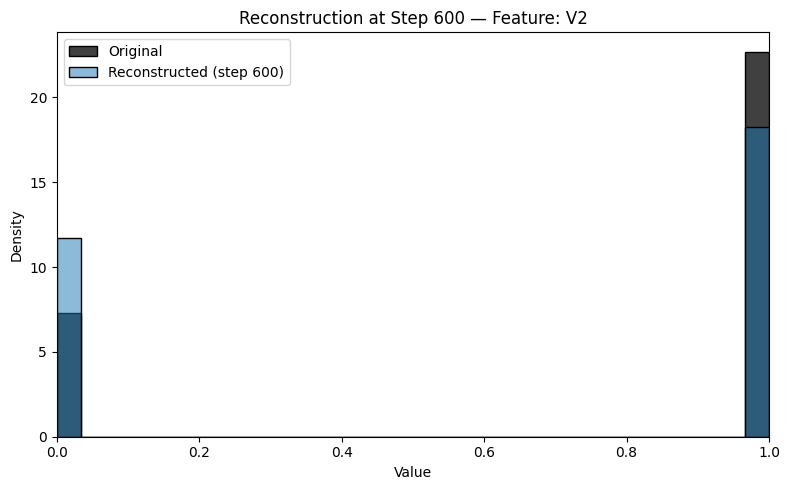

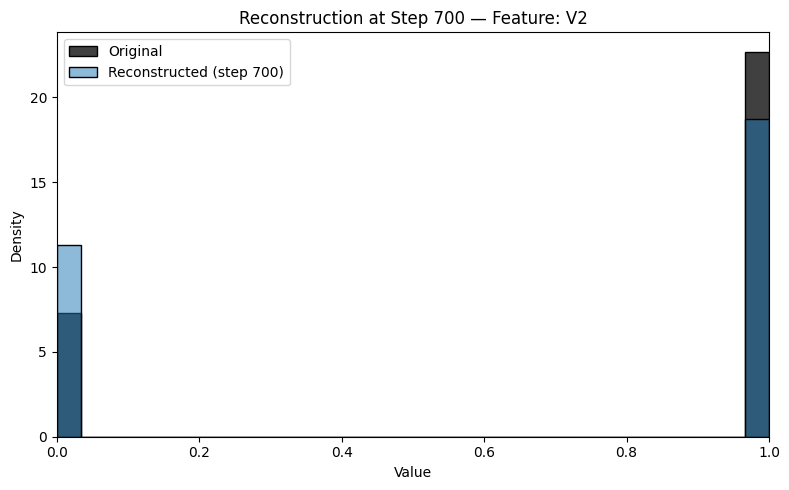

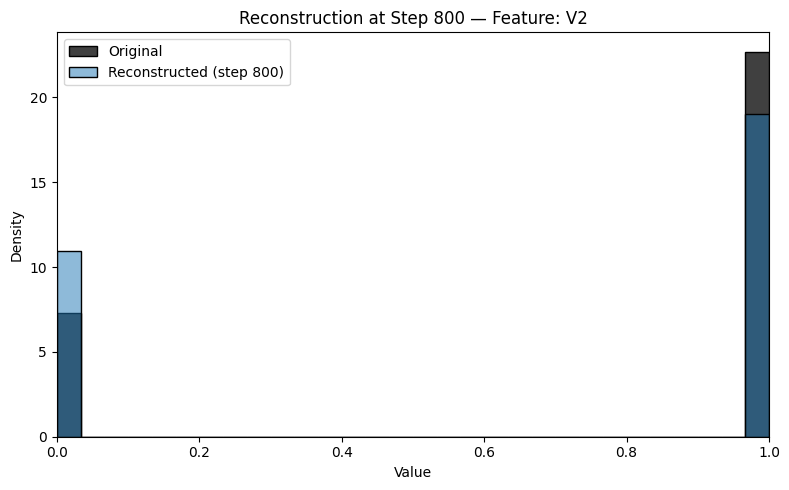

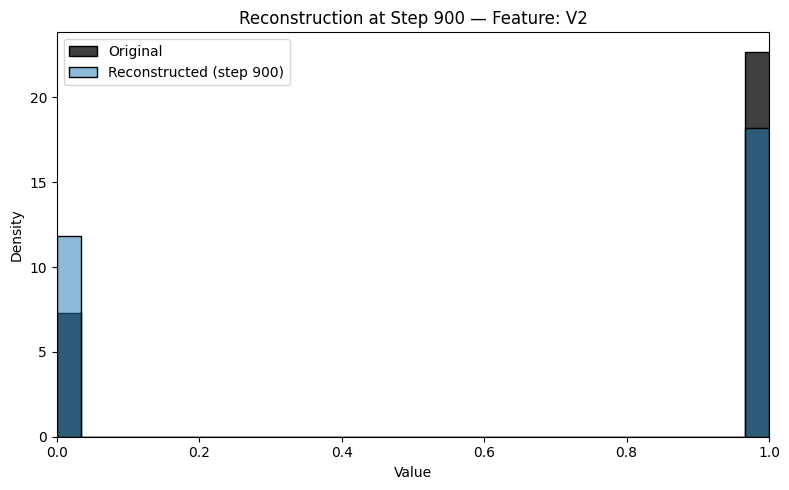

In [10]:
for i in range(len(df.columns)):
    plot_reconstruction_evolution(df, reconstruction_dfs, i)
